## **Introduction**

During their lifetime, aircraft components
are susceptible to degradation, which affects
directly their reliability and performance.
This machine learning project will be directed to provide a framework for **predicting the aircraft’s remaining useful life (RUL)**
based on the entire life cycle data in order
to provide the necessary maintenance behavior. Diverse regression, classification
models (KNN, Naïve Bayes, Random Forest,
SVM, etc..) are deployed and tested on the
NASA’s C-MAPSS data-set to assess the
engine’s lifetime. Please check the report for more theoretical details

<div align='center' > <img src='https://i.postimg.cc/gcvWCNHf/Turbofan-operation-lbp.png'>
 </div>

<div align='center' > Illustration of a turbofan engine </div>

Our focus will be the prediction of the
RUL of the turbofan engine considering
HPC failure and more precisely capturing
low RUL values to avoid putting the engine
on risk.

This notebook will go through : Data inspection & pre-processing,Exploratory Data Analysis and Data visualization, Feature engineering, Model Building, Training and Testing (Regression) and Comparing Actual vs Predicted values.

## **Importing initially important libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Note : make sure to adapt the way data is collected to your environment (If you're working on kaggle you can easily click on add data then choose nasa-cmaps data).

## **Defining features names**

i.e., Attributes/parameters

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

## **Importing train and validation data**

FD001 subset corresponds to HPC failure of the engine.

Note: train data will be splitted to train/test sets in the modeling part.

In [3]:
dftrain = pd.read_csv('../input/nasa-cmaps/CMaps/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('../input/nasa-cmaps/CMaps/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('../input/nasa-cmaps/CMaps/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [4]:
y_valid

RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

In [5]:
dftrain.shape
dfvalid.shape

(13096, 26)

In [6]:
train = dftrain.copy()
valid = dfvalid.copy()

## Data inspection

Checking for null/NaN values

In [7]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
20626  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
20627  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
20628  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
20629  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
20630  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
20626  0.03   397  2388  100.0  38.49  22.9735  
20627  0.03   395  2388  100.0  38.30  23.1594  
20628  0.03   398  2388  100.0  38.44  22.9333  
20629  0.03   395  2388  100.0  38.29  23.0640  
20630  0.03   396  2388  100.0  38.37  23.0522  

[20631 rows x 26 columns]

The dataset FD001 contains time series of 21 sensors and 3 settings of 100 units(turbofan engine).Each engine works normally at the beginning of each time series and fails at the end of the time series. Each row is a snapshot of the data taken during a single operation cycle.

In [8]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


In [9]:
#Cheking the presence of Nan values
print('Total None values in the train dataset : ',train.isna().sum())

Total None values in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


No missing value is detected

In [10]:
train.loc[:,['unit_number','time_cycles']].describe()

unit_number   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

When we inspect the descriptive statistics of unit_nr we can see the dataset has a total of 20631 rows, unit numbers start at 1 and end at 100 as expected. What’s interesting, is that the mean and quantiles don’t align neatly with the descriptive statistics of a vector from 1–100, this can be explained due to each unit having different max time_cycles and thus a different number of rows. The average unit has gone through 108.81 cycles. There is a large spread in the number of cycles, with a standard deviation of 68.88. Half of the units have gone through at least 104 cycles. The minimum number of cycles is 1, and the maximum number of cycles(operated longest before broke down) is 362. There are likely outliers on both the low and high ends of the distribution, as the minimum and maximum values are far from the quartiles.We’ll visualize this further down below to get an even better understanding.

In [11]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  0.000000e+00     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.387812e-17     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

## **EDA, Data visualization & Feature engineering**

### Max time cycle found for each Unit

Let us see the maximum time cycle of each unit

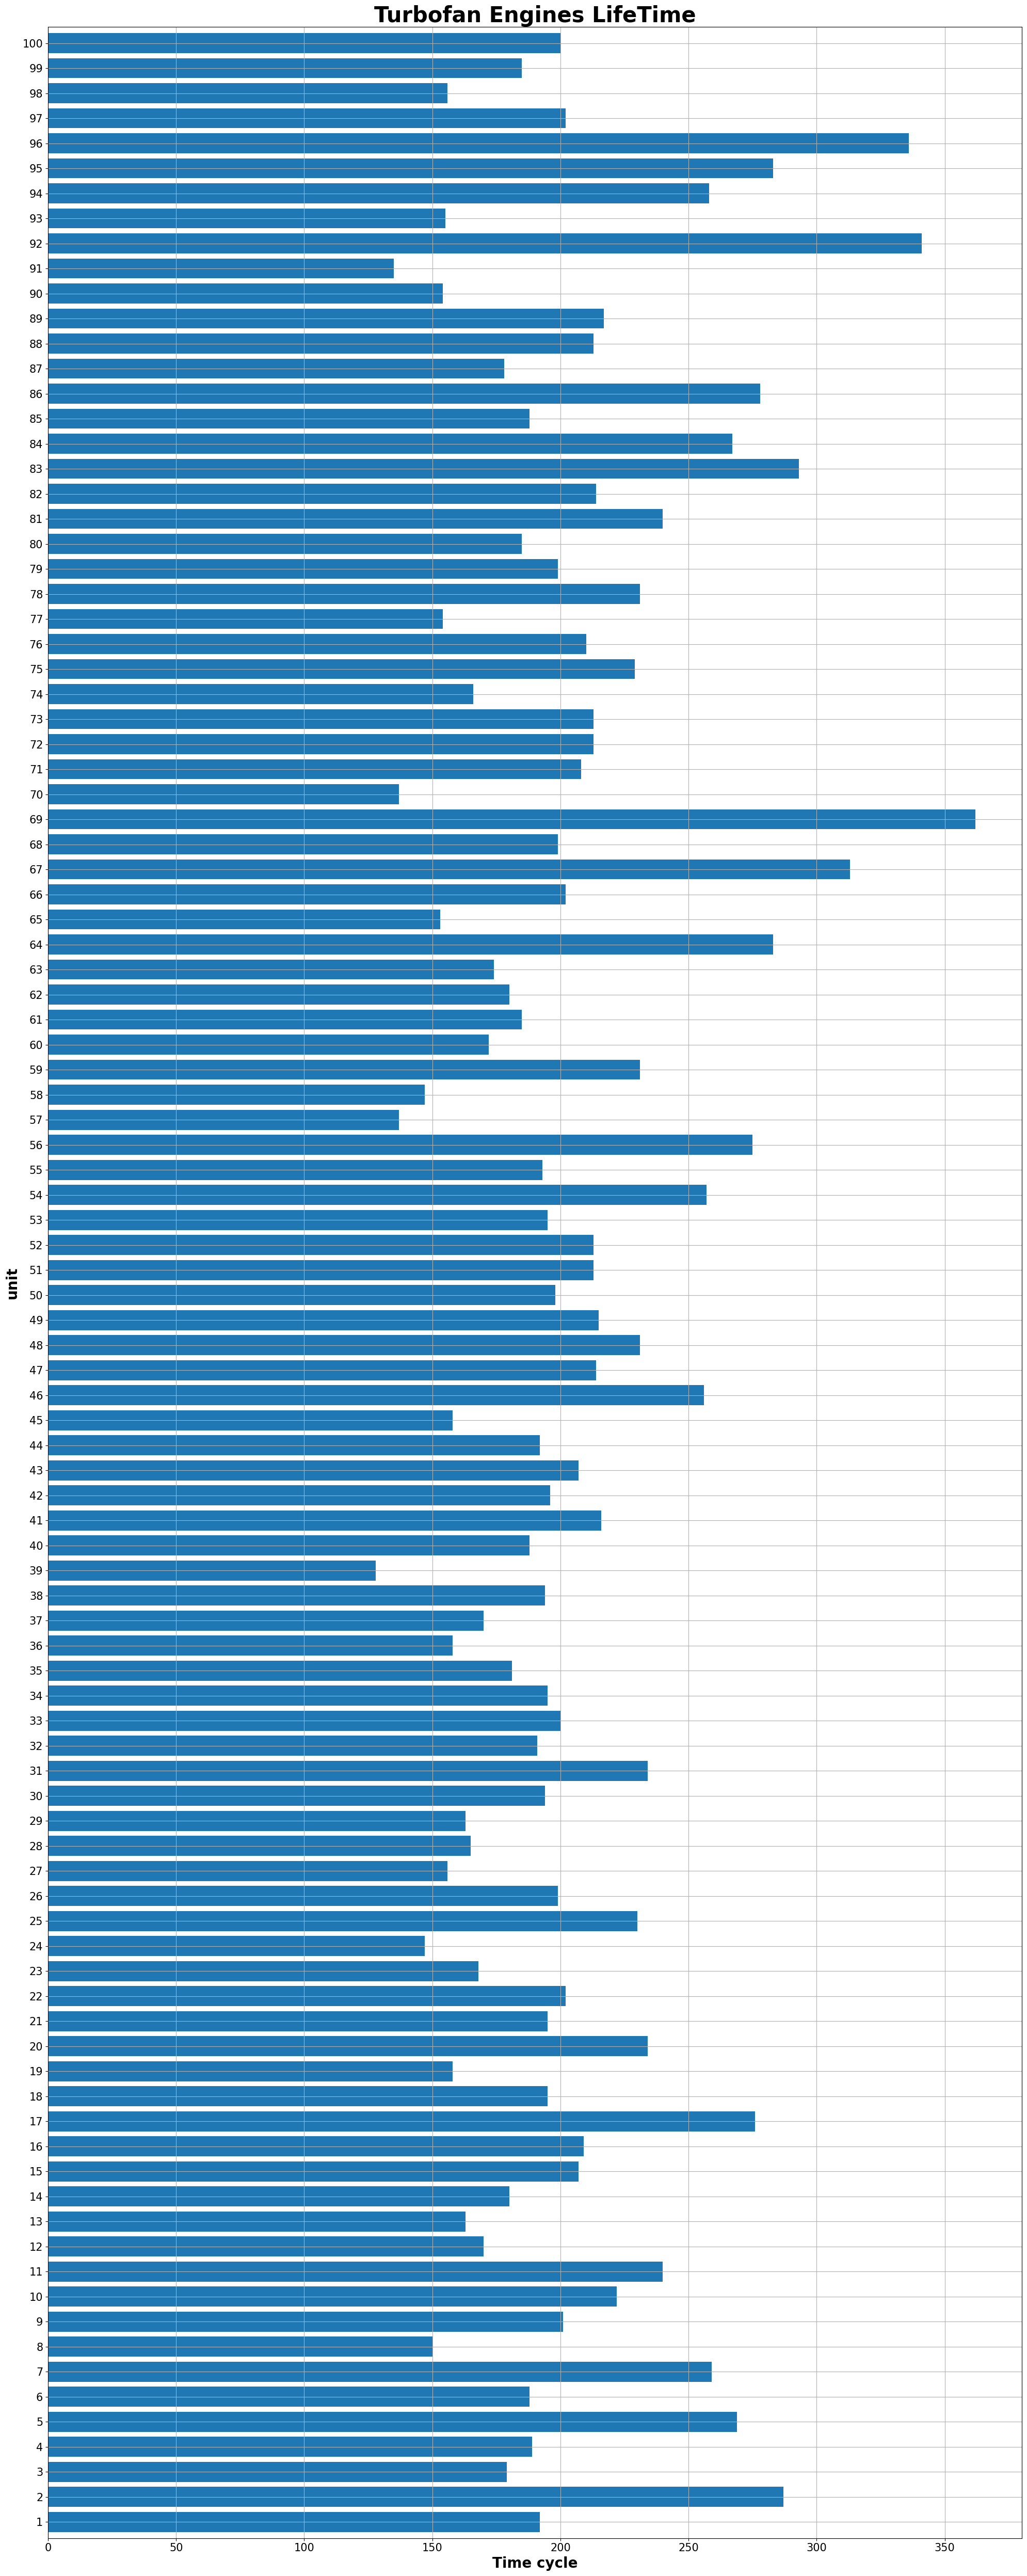

In [12]:
max_time_cycles=train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'max time cycle')

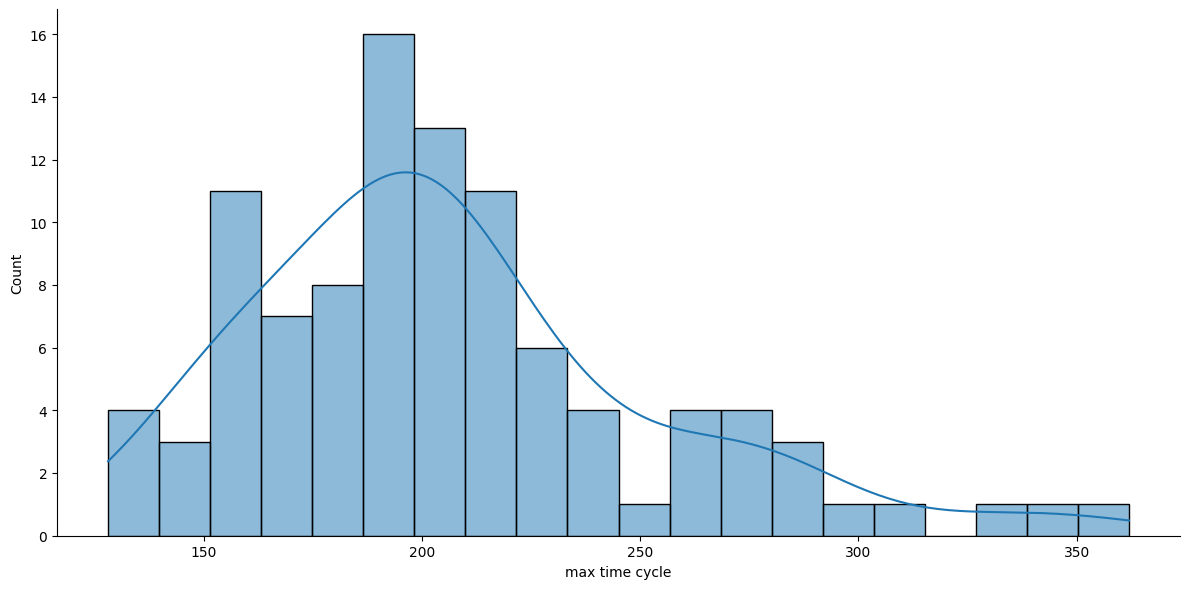

In [13]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

We notice that in most of the time, the maximum time cycles that an engine can achieve is between 190 and 210 before HPC failure.

### Add RUL column to the data

#### RUL  corresponds to the remaining time cycles for each unit before it fails.

In [14]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [15]:
train = add_RUL_column(train)

In [16]:
train[['unit_number','RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

In [17]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1          192     0.0047     0.0005      100.0  518.67  644.21   
1            2          287     0.0076     0.0006      100.0  518.67  643.94   
2            3          179     0.0058     0.0005      100.0  518.67  643.93   
3            4          189     0.0059     0.0006      100.0  518.67  644.53   
4            5          269     0.0055     0.0005      100.0  518.67  644.02   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1  1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2  1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3  1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4  1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.18  23.4999  191  
1  100.0  39.24  23.6005  286  
2  100.0  39.23  23.5181  178  
3  100.0  39.21  23.5074  188  
4  100.0  39.29  23.5503  268  

[5 rows x 27 columns]

### Discovering Correlations

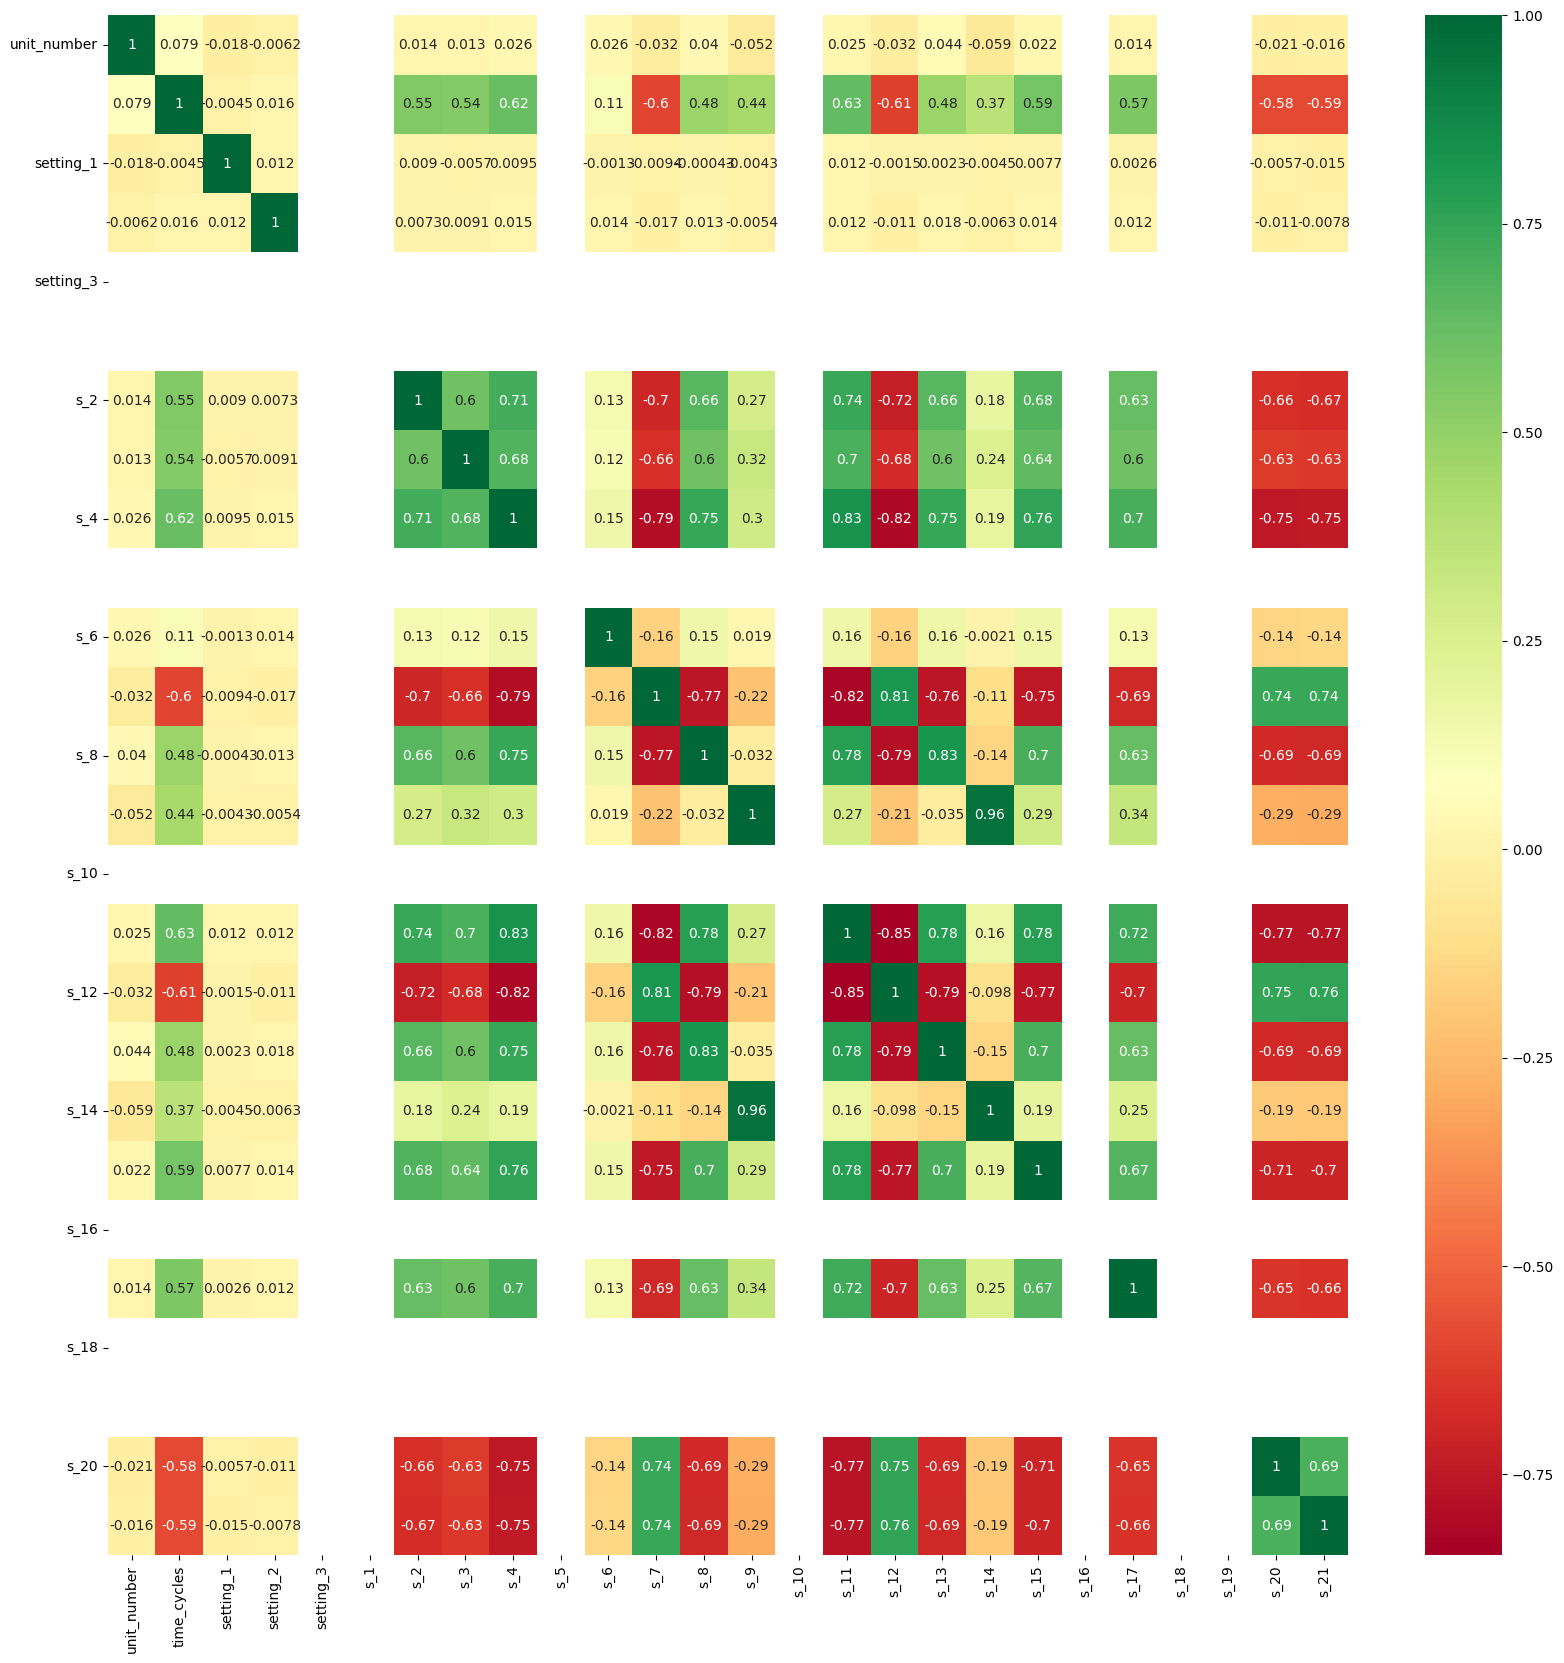

In [18]:
sns.heatmap(dftrain.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

Generate the Correlation Matrix:

df.corr() calculates the correlation matrix for the DataFrame df.

Create a Heatmap:

* sns.heatmap(...) generates a heatmap using Seaborn.
* df.corr(): The correlation matrix.
* annot=True: Displays the correlation values in each cell.
* cmap='RdYlGn': Specifies the color map (Red-Yellow-Green).
* linewidths=0.2: Sets the width of the lines that divide each cell in the heatmap.

Set Figure Size:

* fig = plt.gcf(): Gets the current figure.
* fig.set_size_inches(20, 20): Sets the size of the figure to 20x20 inches.
* Display the Heatmap:

plt.show(): Displays the generated heatmap.

<Axes: >

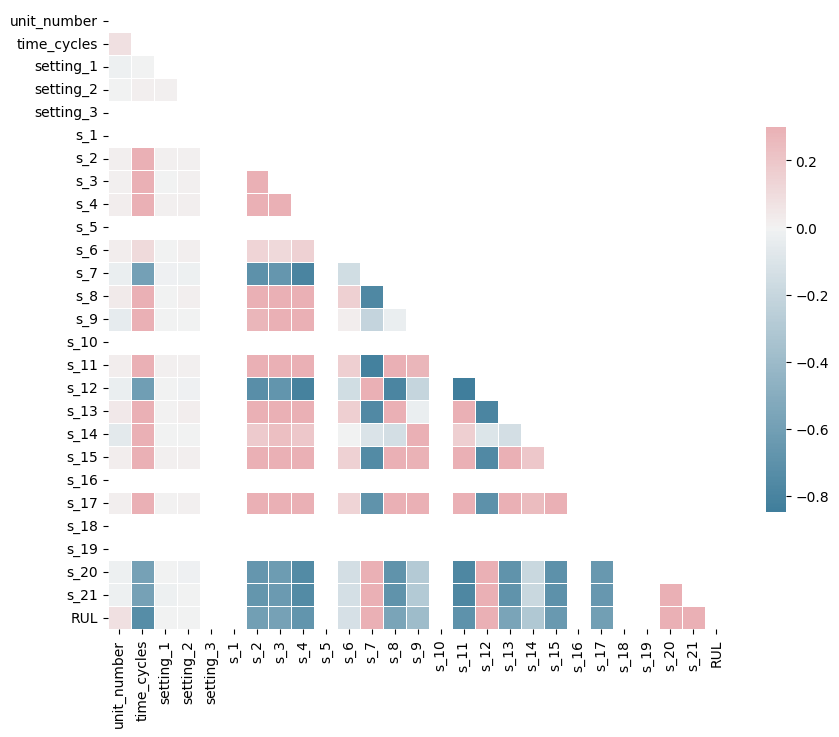

In [19]:
# Compute the correlation matrix
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Compute the Correlation Matrix:

train.corr() calculates the correlation matrix for the 'train' DataFrame. The correlation matrix shows the correlation coefficients between different pairs of columns in the DataFrame.
Create a Mask for the Upper Triangle:

np.triu(np.ones_like(corr, dtype=bool)) creates a boolean mask to hide the upper triangle of the correlation matrix. This is done to avoid redundancy since the correlation matrix is symmetric.
Set up the Matplotlib Figure and Axes:

f, ax = plt.subplots(figsize=(10, 10)) creates a Matplotlib figure (f) and axes (ax) with a specified size of 10x10 inches.

Define the Color Map for the Heatmap:

cmap = sns.diverging_palette(230, 10, as_cmap=True) defines a color map for the heatmap. It uses a diverging color palette from blue (230) to orange (10).

Draw the Heatmap:

* sns.heatmap(...) draws the heatmap using Seaborn.
* corr: The correlation matrix.
* mask: The upper triangle mask.
* cmap: The color map.
* vmax: Maximum value for color normalization.
* center: Center value for color mapping.
* square: Display the plot as a square.
* linewidths: Width of the lines that divide each cell.
* cbar_kws={"shrink": .5}: Keyword arguments for configuring the color bar, in this case, shrinking it to 50% of its original size.

We notice that some features of our data-set are highly correlated with the target value RUL, other features present a low correlation which will be dropped later.

## Questions to answer :

- Can we efficiently predict the remaining useful time for the engine (error significance) ?
- Which features are the most important for predicting the failure of the turbofan engine ?
- Does adding historical data improve our model ?
- Is the collected data sufficient enough to give an accurate prediction ?
- How can we turn our problem to a classification one ?


First, let us match each sensor with its real signification

In [20]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

A **low pressure compressor (LPC**) and **high pressure compressor
(HPC**) supply compressed high temperature, high pressure gases to the combustor.
**Low pressure turbine (LPT)** can decelerate and pressurize air to improve the chemical energy
conversion efficiency of aviation kerosene.
**High pressure turbines (HPT)** generate mechanical energy by using high temperature and high pressure gas strike turbine blades.
**Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle** guarantee the combustion
efficiency of the engine.

### Plotting the evolution of features (sensors) along with the evolution with RUL

In [21]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()


Function Definition:

def plot_signal(df, Sensor_dic, signal_name):: Defines a function named plot_signal that takes three parameters: a DataFrame (df), a dictionary mapping sensor names to their descriptions (Sensor_dic), and the name of the signal to be plotted (signal_name).

Plotting Sensor Signals:

* for i in df['unit_number'].unique():: Iterates over unique unit numbers in the DataFrame.
* if (i % 10 == 0):: Checks if the unit number is a multiple of 10 (e.g., 10, 20, 30, ...). This is done to visualize signals for a subset of units for better clarity.
* plt.plot('RUL', signal_name, data=df[df['unit_number'] == i].rolling(10).mean()): Plots the rolling mean of the specified sensor signal over RUL for the selected units.

Plot Customization:

* plt.xlim(250, 0): Sets the x-axis limits to reverse the order of RUL (counts down to zero).
* plt.xticks(np.arange(0, 300, 25)): Sets custom x-axis ticks.
* plt.ylabel(Sensor_dic[signal_name]): Sets the y-axis label using the sensor description from the dictionary.
* plt.xlabel('Remaining Useful Life'): Sets the x-axis label.

Display the Plot:

plt.show(): Displays the generated plot.

This function is designed to visualize sensor signals over the Remaining Useful Life for a subset of units. The rolling mean is applied to smoothen the curves. You can customize the function by adjusting parameters and labels based on your specific dataset and visualization preferences.

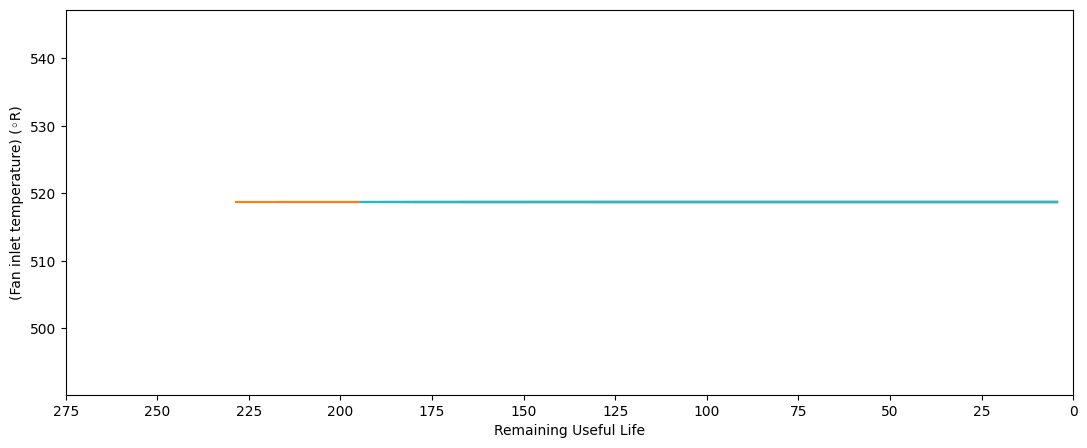

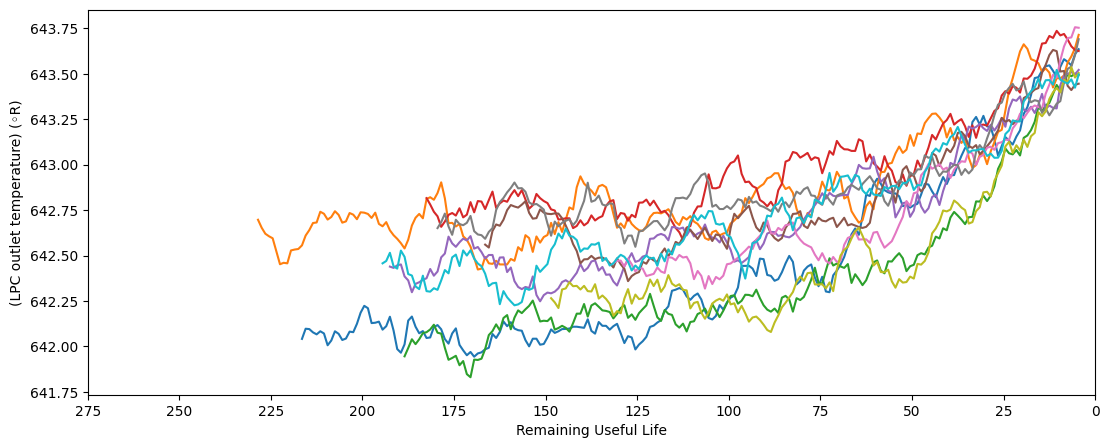

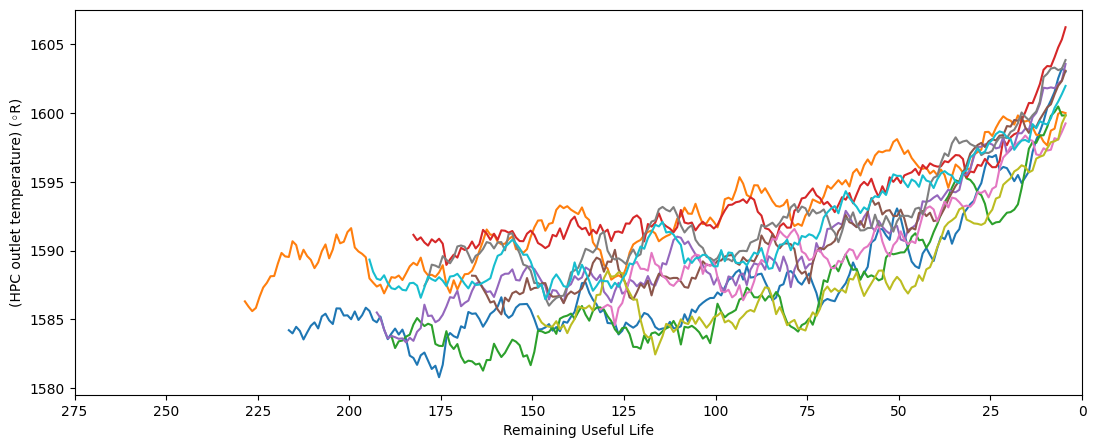

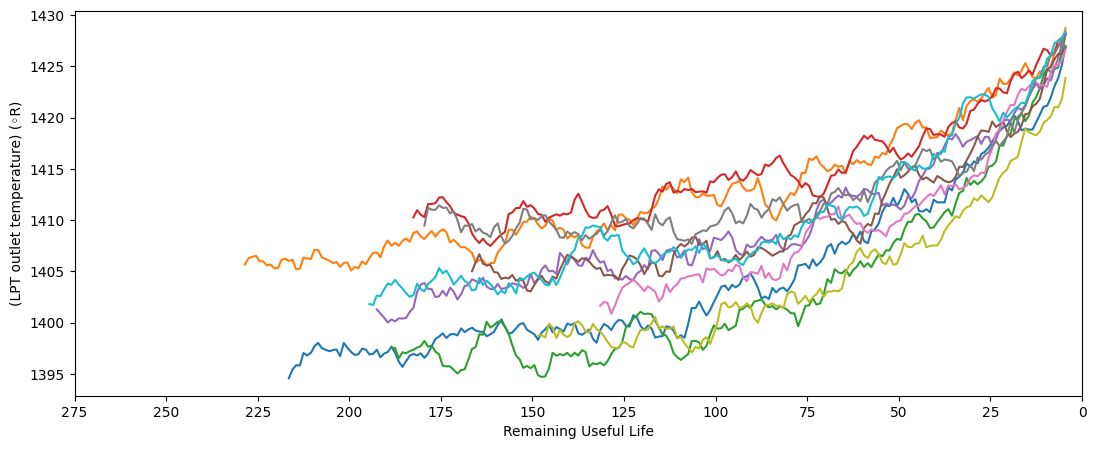

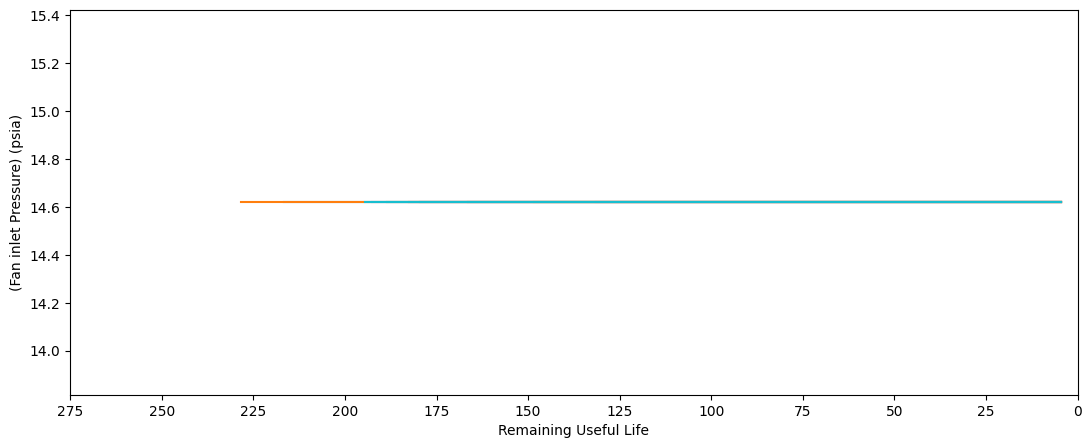

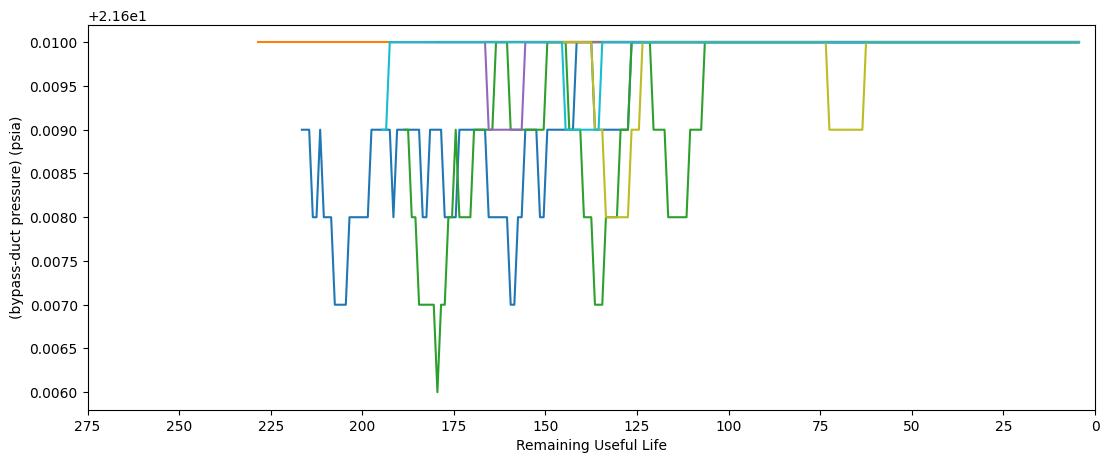

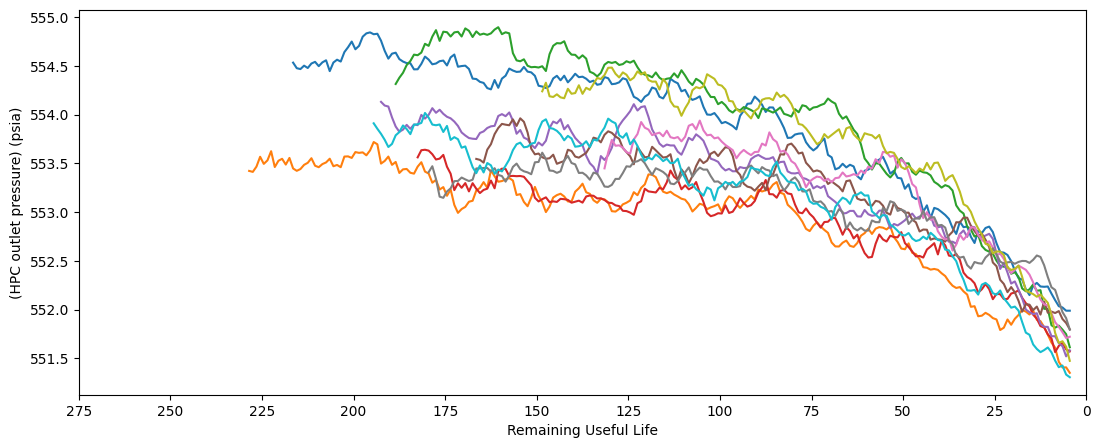

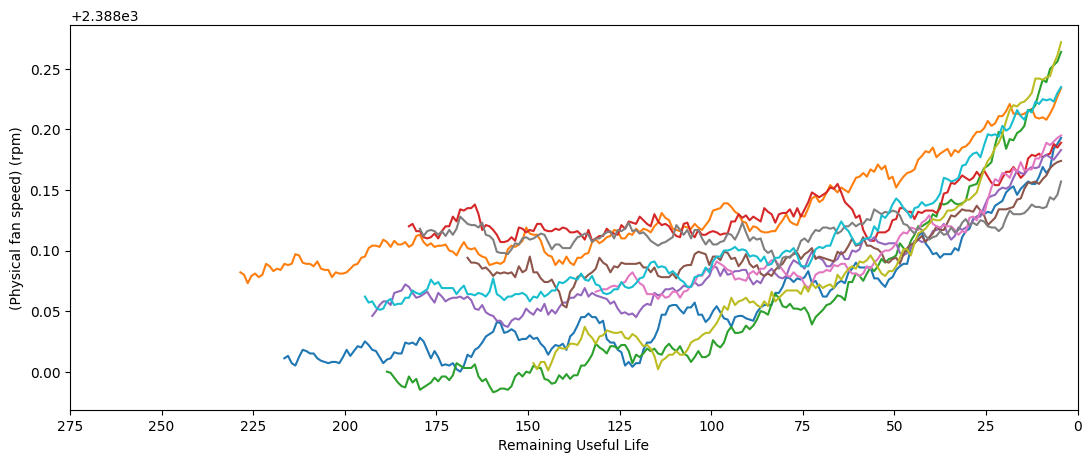

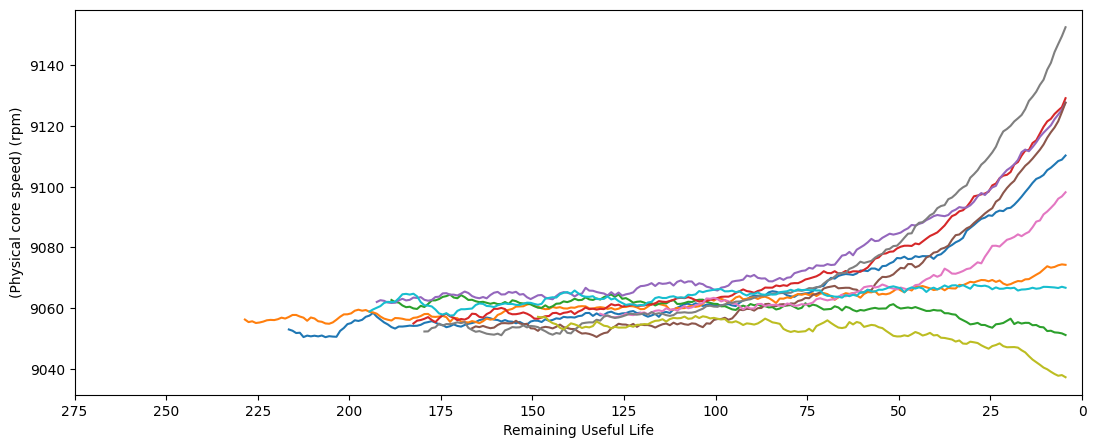

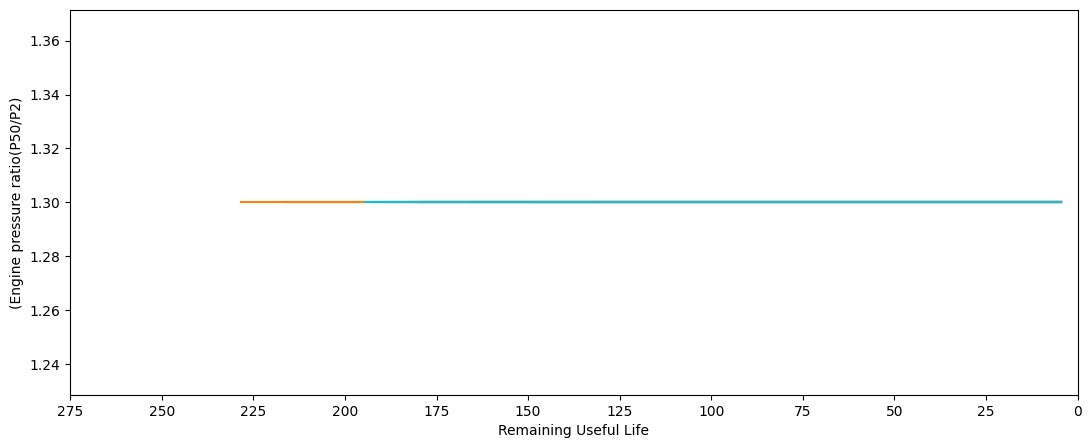

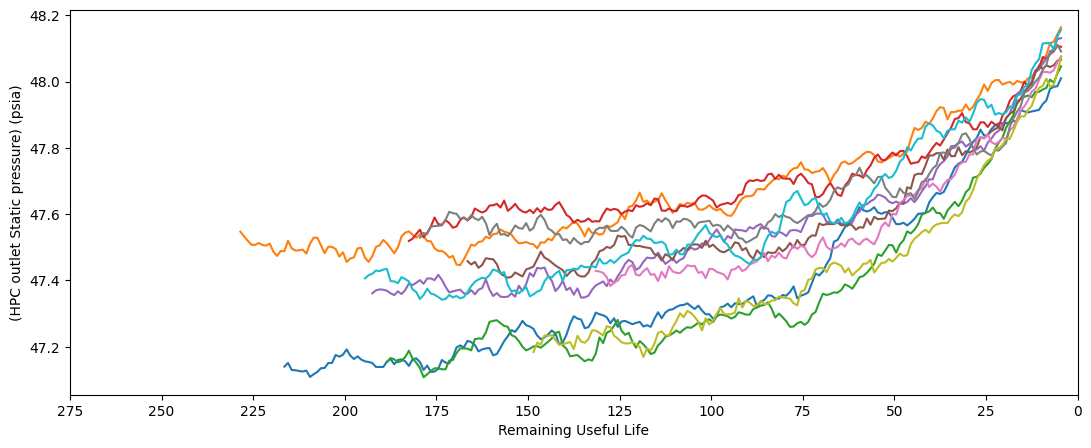

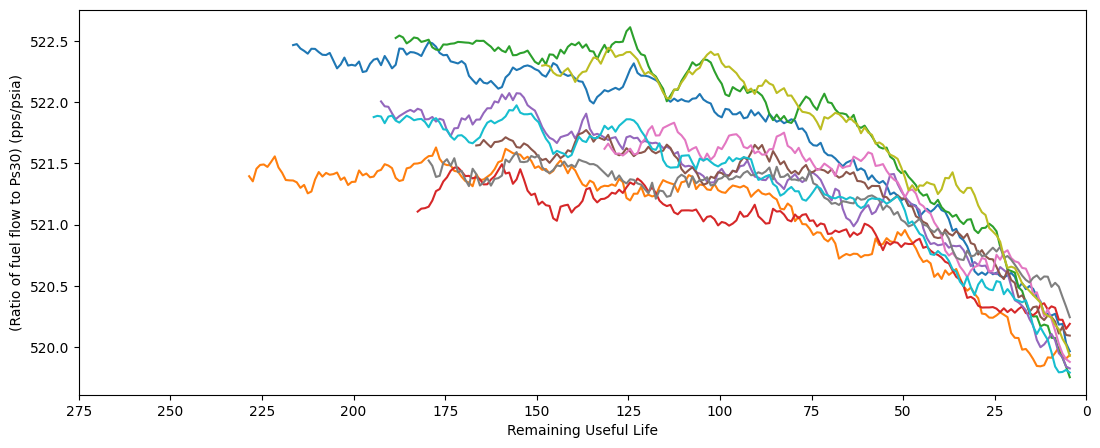

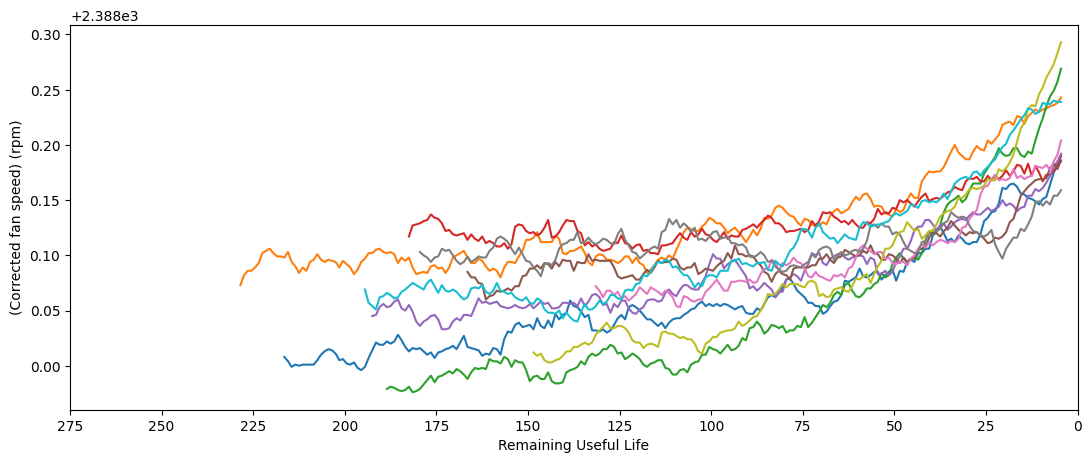

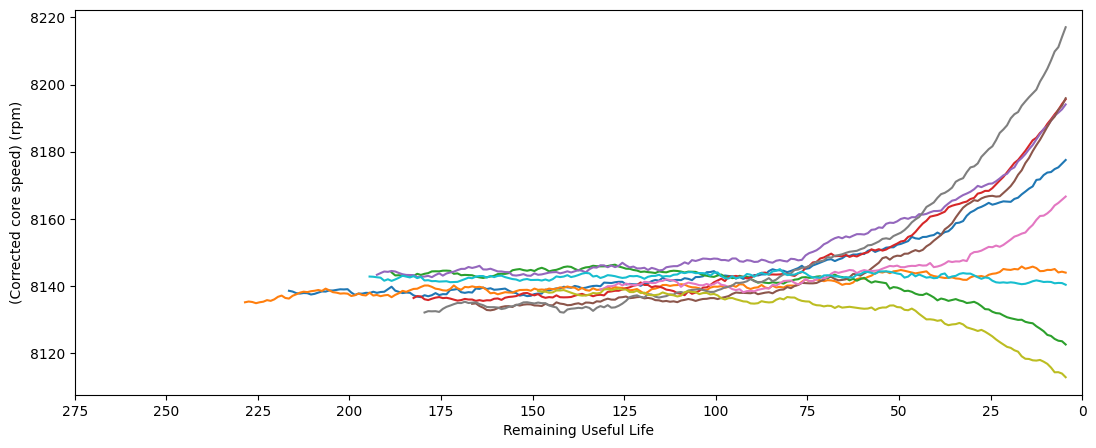

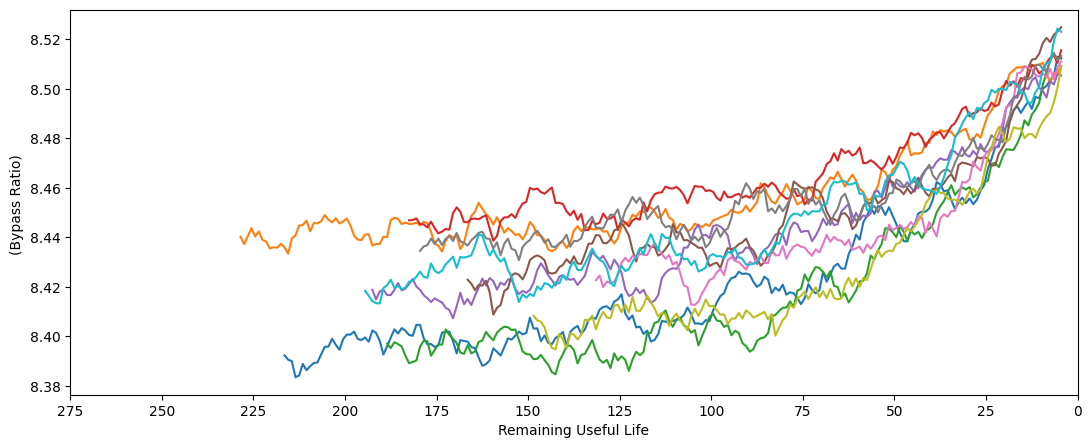

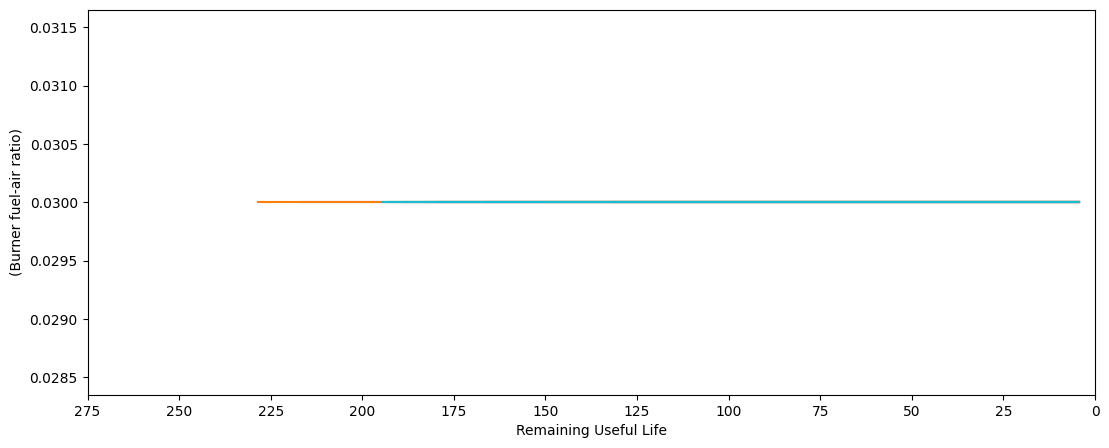

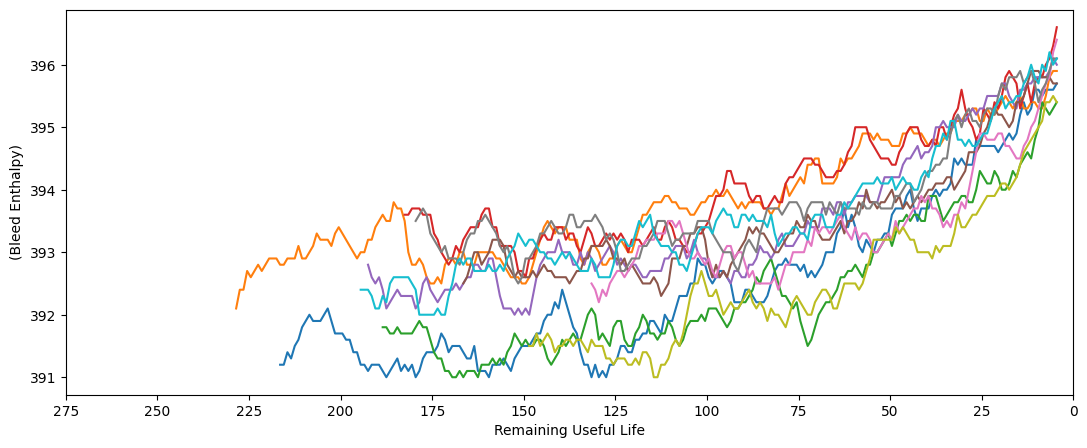

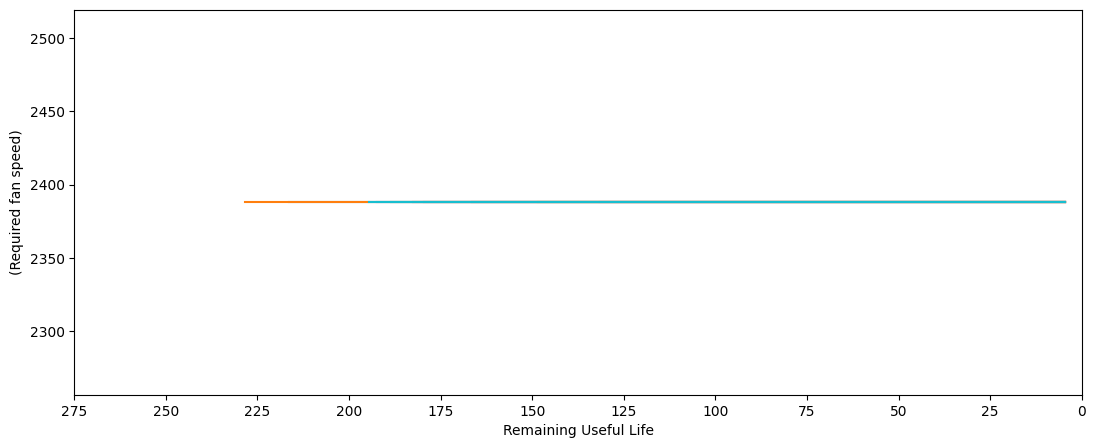

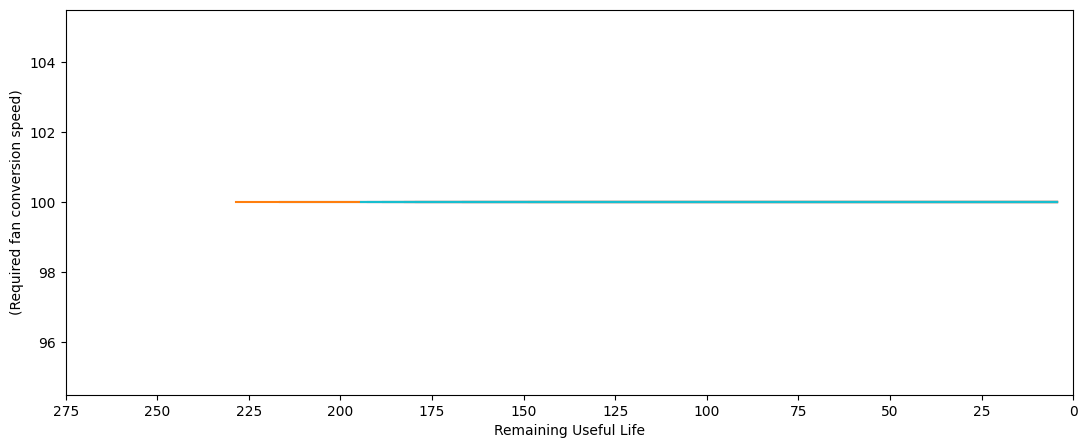

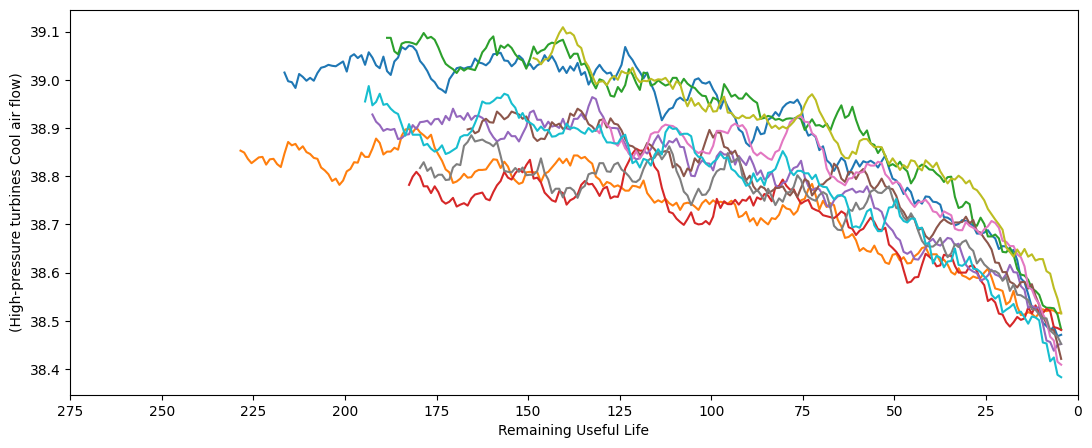

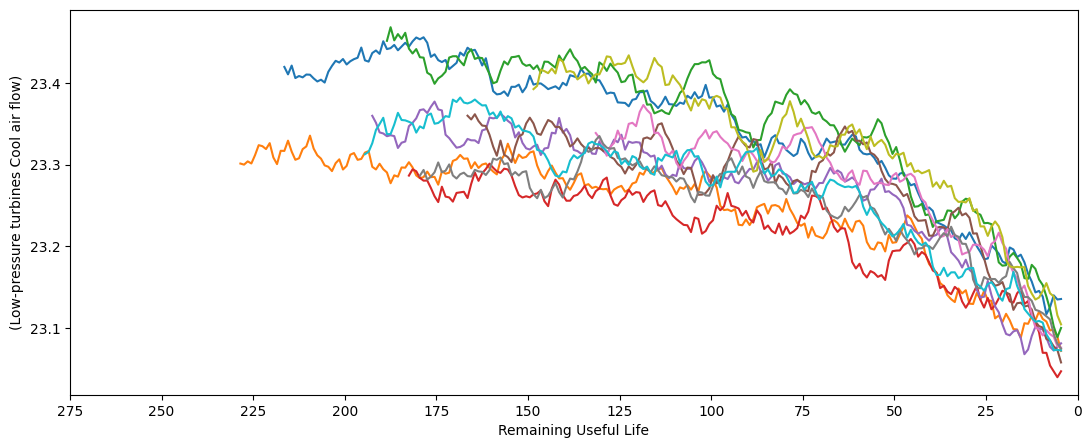

In [22]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

These plots show that some sensors are constant. Hence they don't influence the RUL ==> we can drop those ones. (later)

For Loop:

for i in range(1, 22):: Iterates over the range of numbers from 1 to 21.

Plotting Attempt:

try:: Attempts to execute the code block within the try block.
plot_signal(train, Sensor_dictionary, 's_' + str(i)): Calls the plot_signal function for the i-th sensor signal ('s_1', 's_2', ..., 's_21').

Exception Handling:

except:: Catches any exceptions that may occur during the execution of the try block.
pass: If an exception occurs, it does nothing and continues to the next iteration of the loop.
This loop is useful for automatically generating plots for multiple sensor signals without the script terminating if there's an issue with one of the plots. It provides a convenient way to visualize a series of sensor signals without manually calling the plot_signal function for each signal.

Adjustments can be made to the loop range or other parameters based on your specific requirements and dataset.

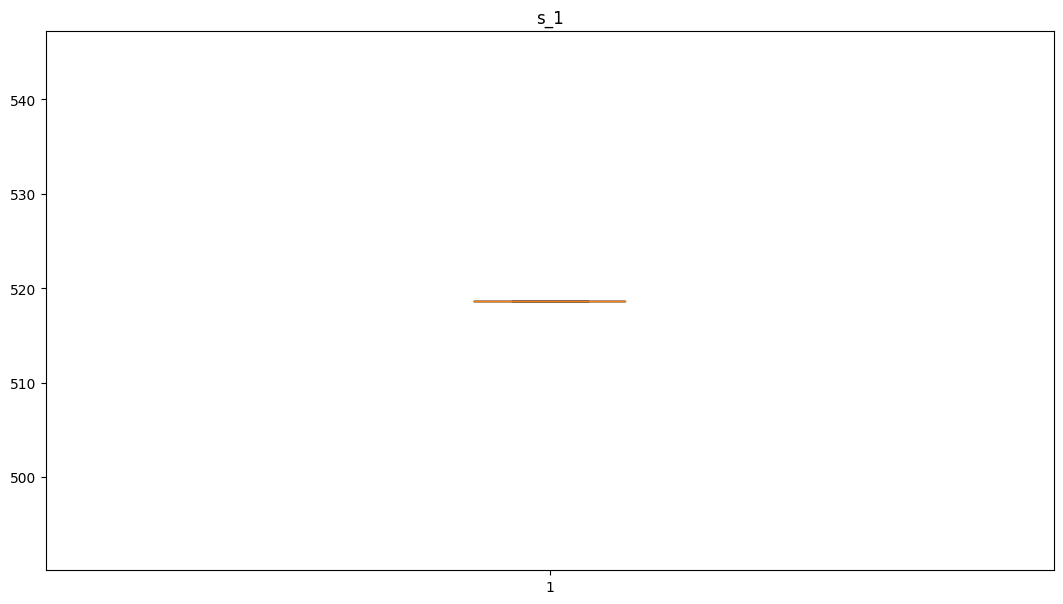

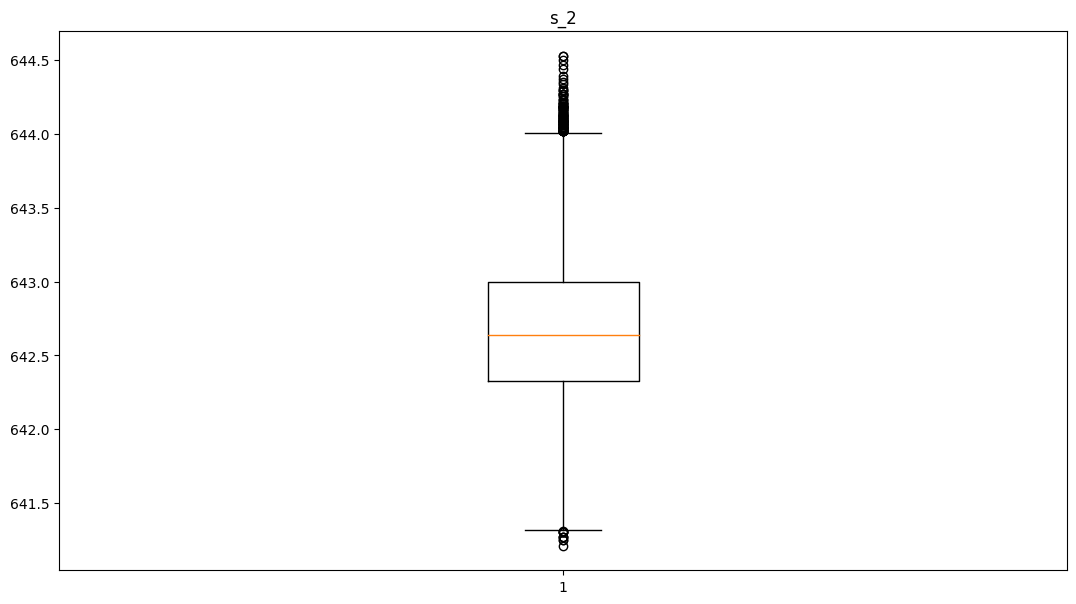

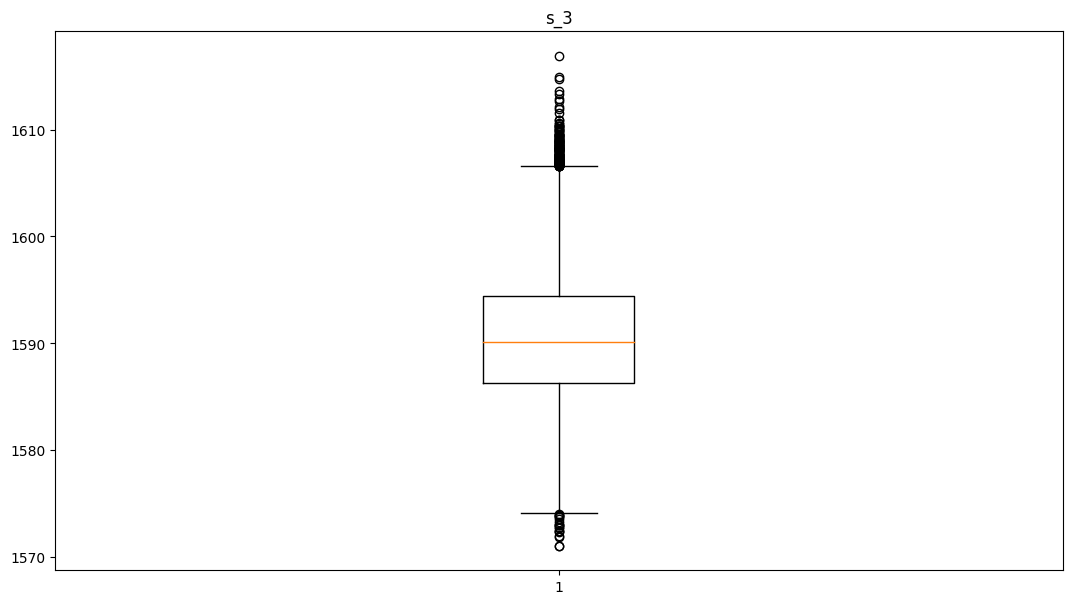

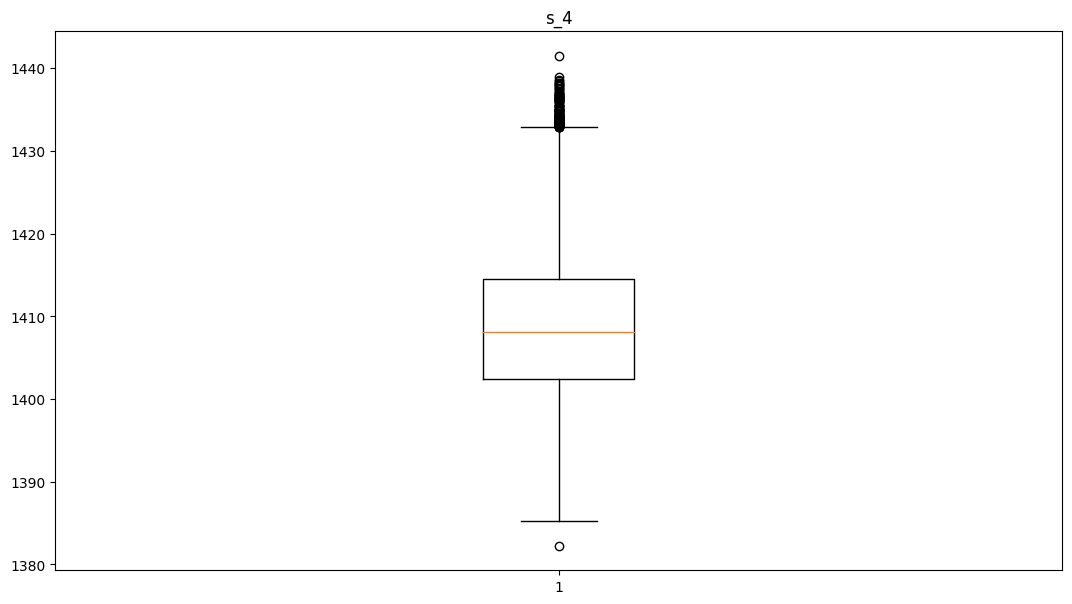

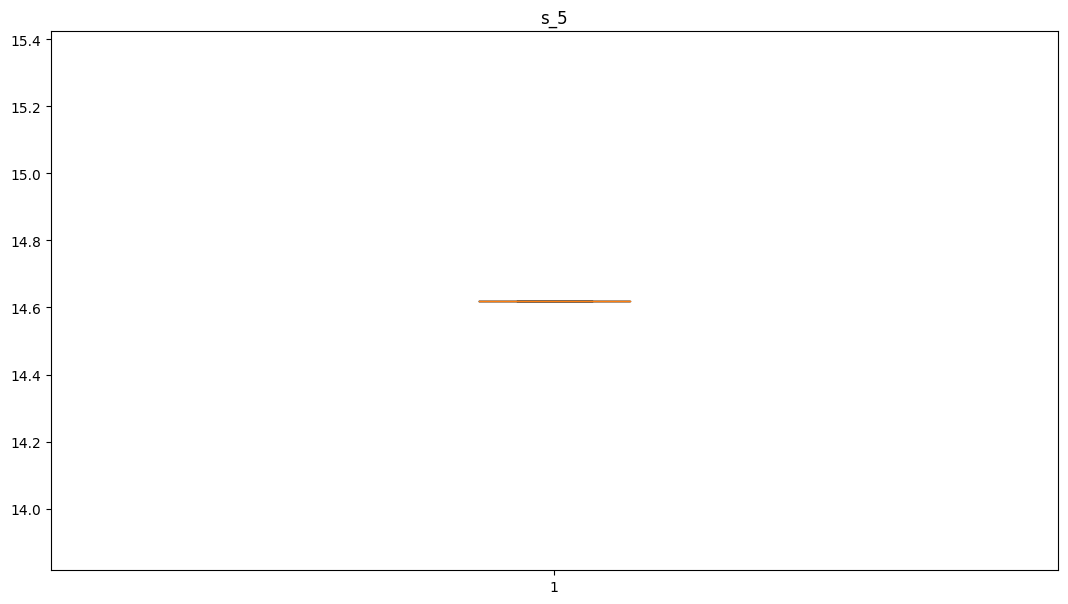

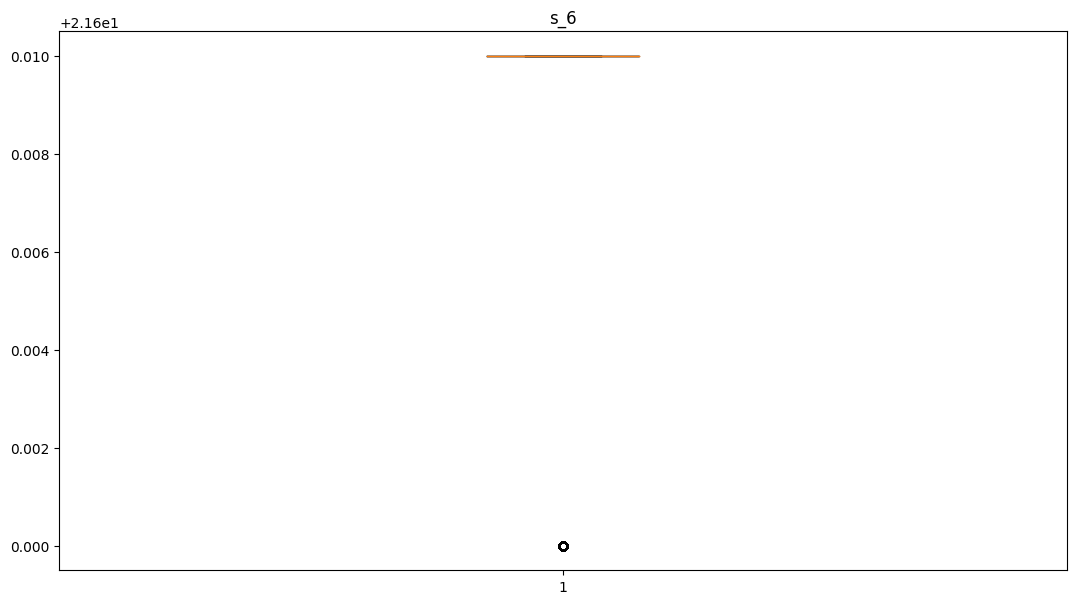

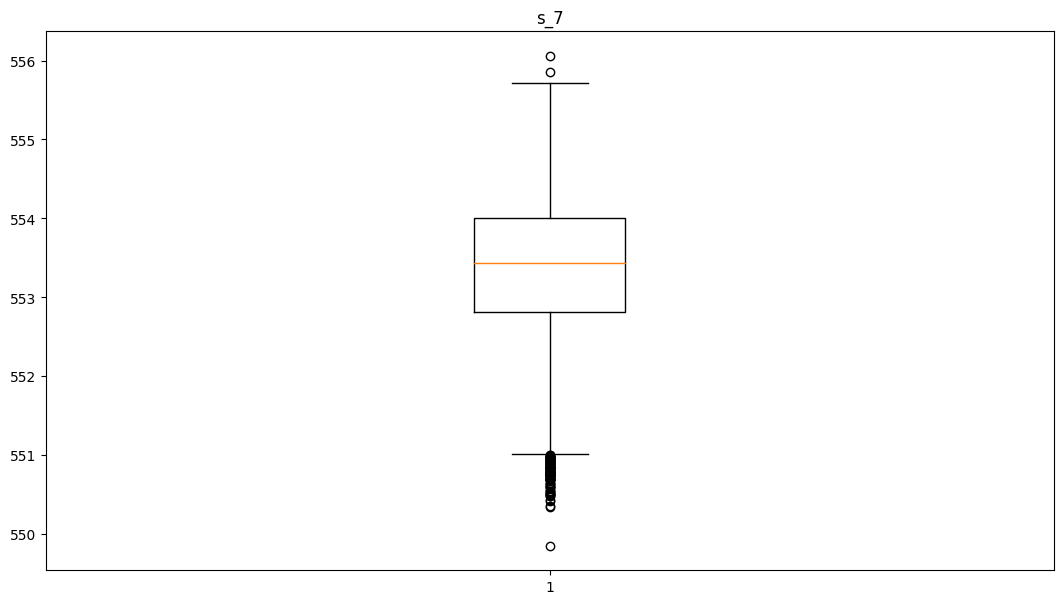

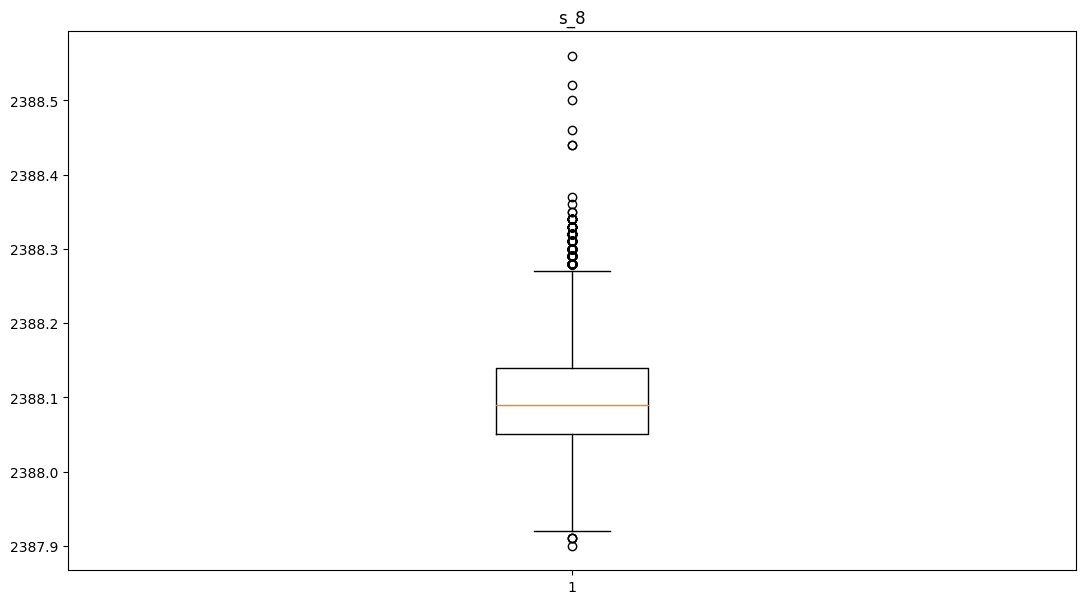

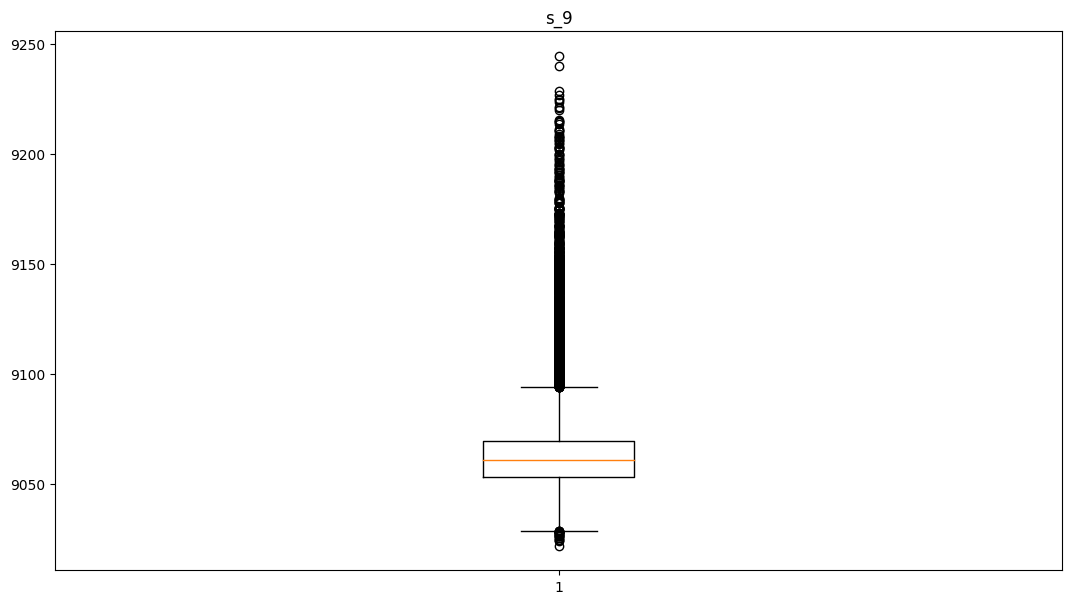

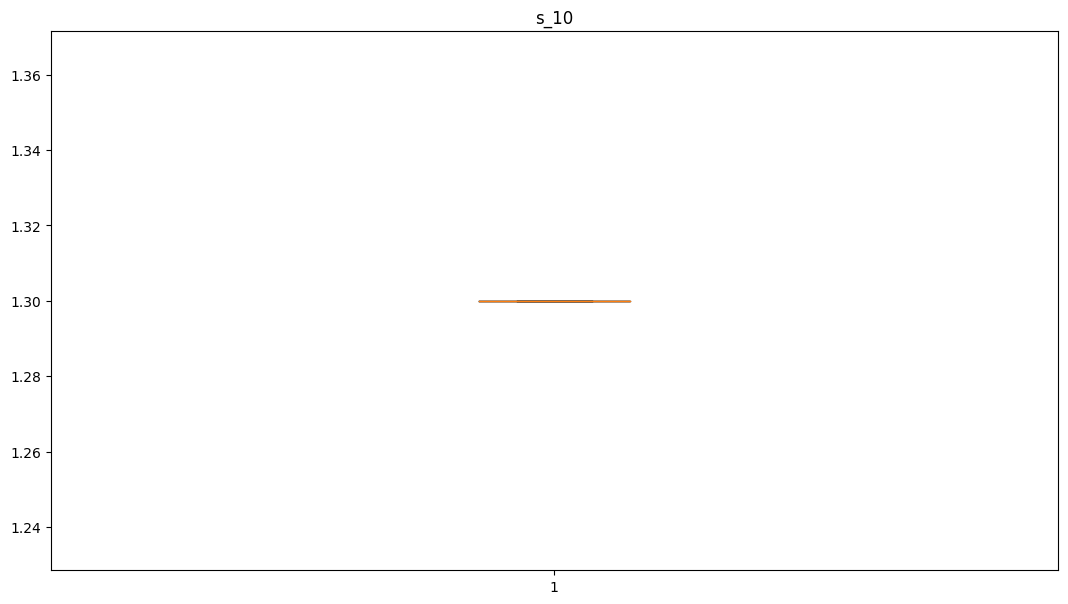

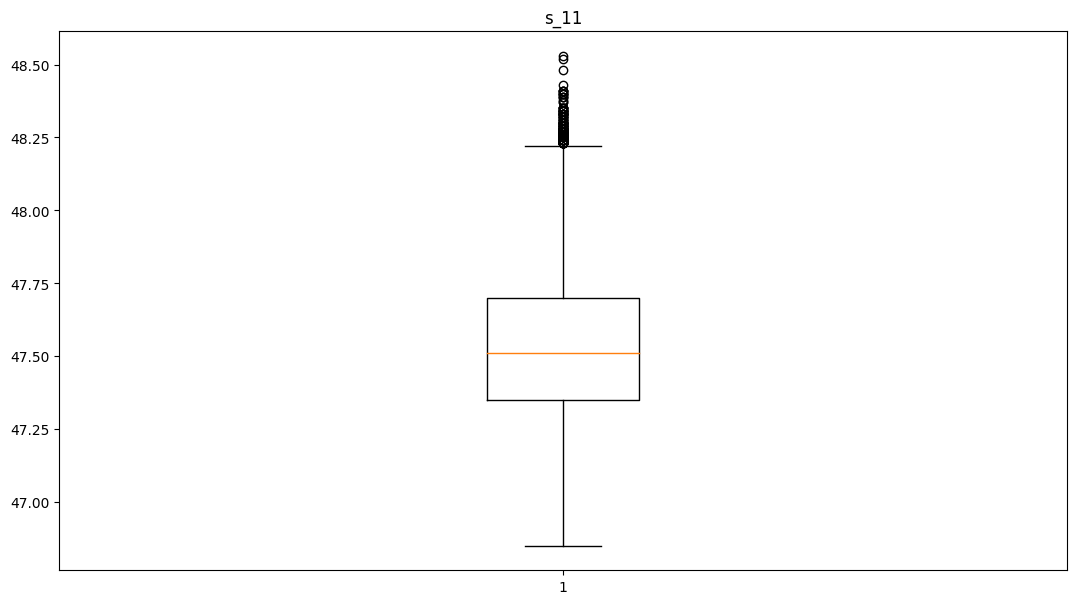

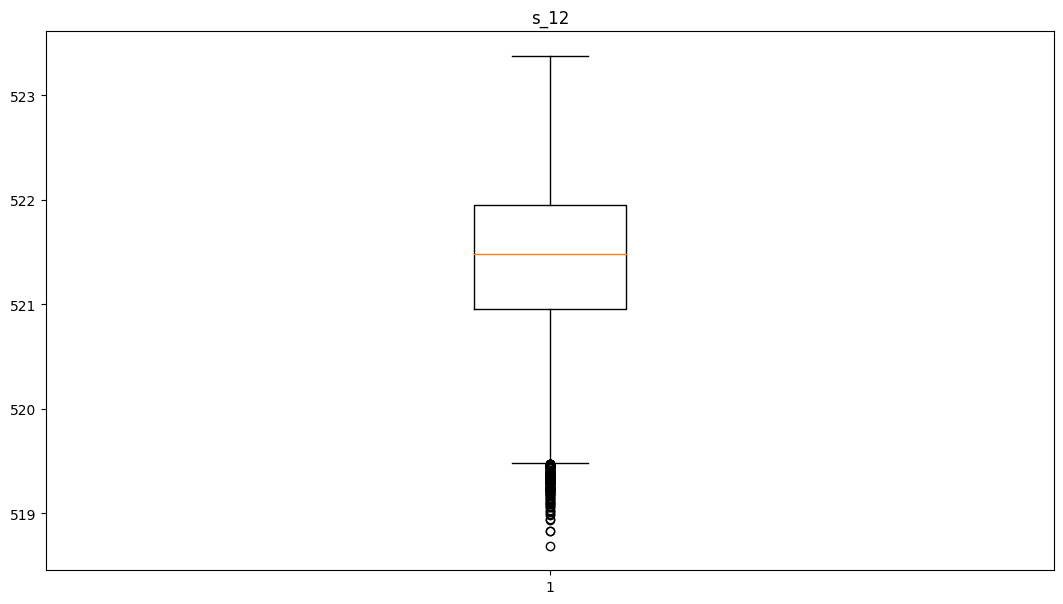

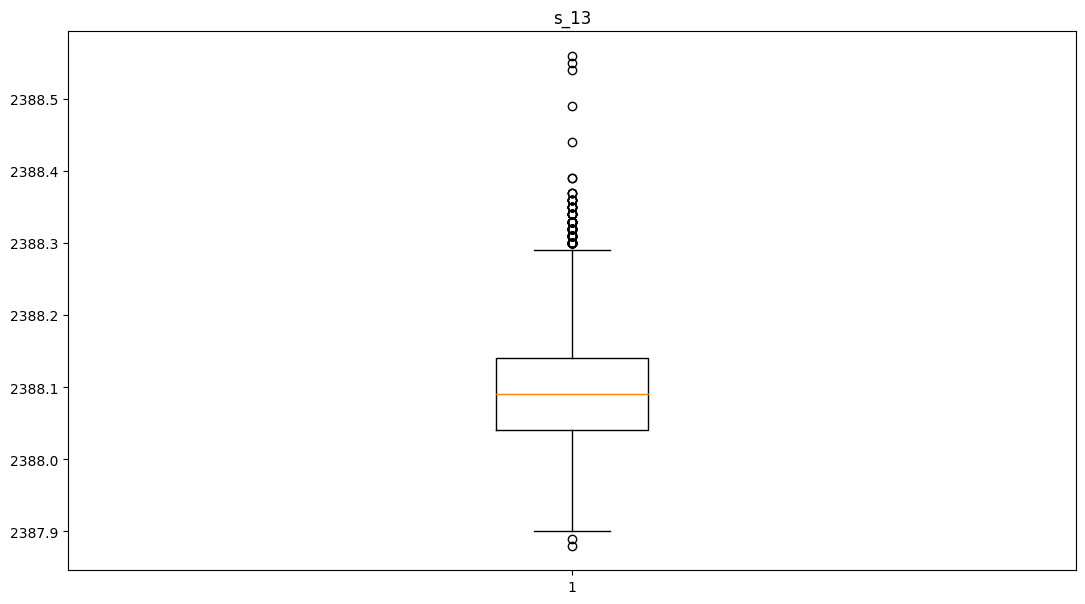

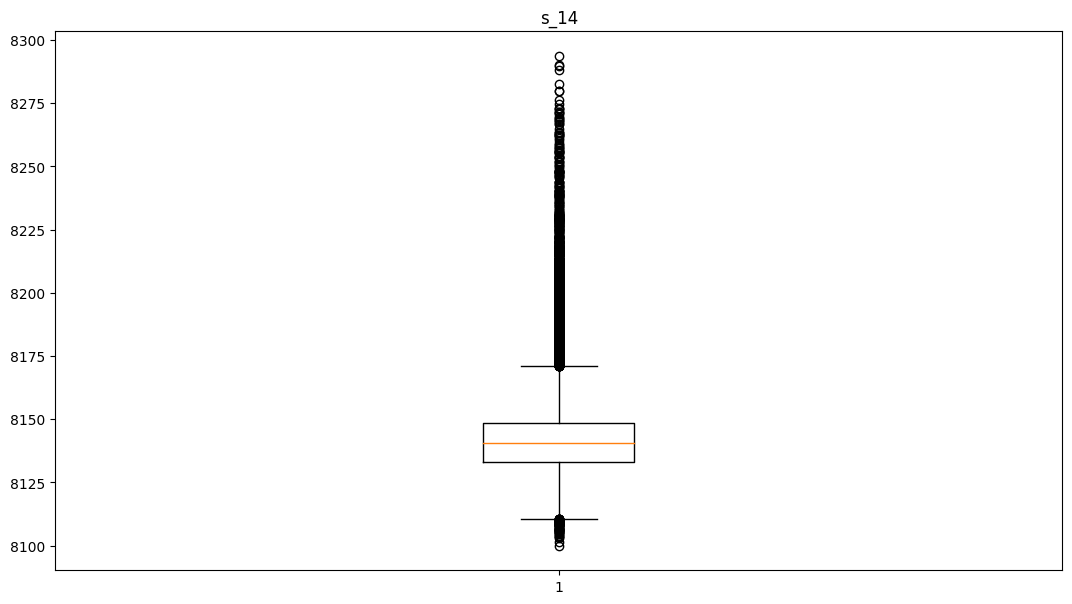

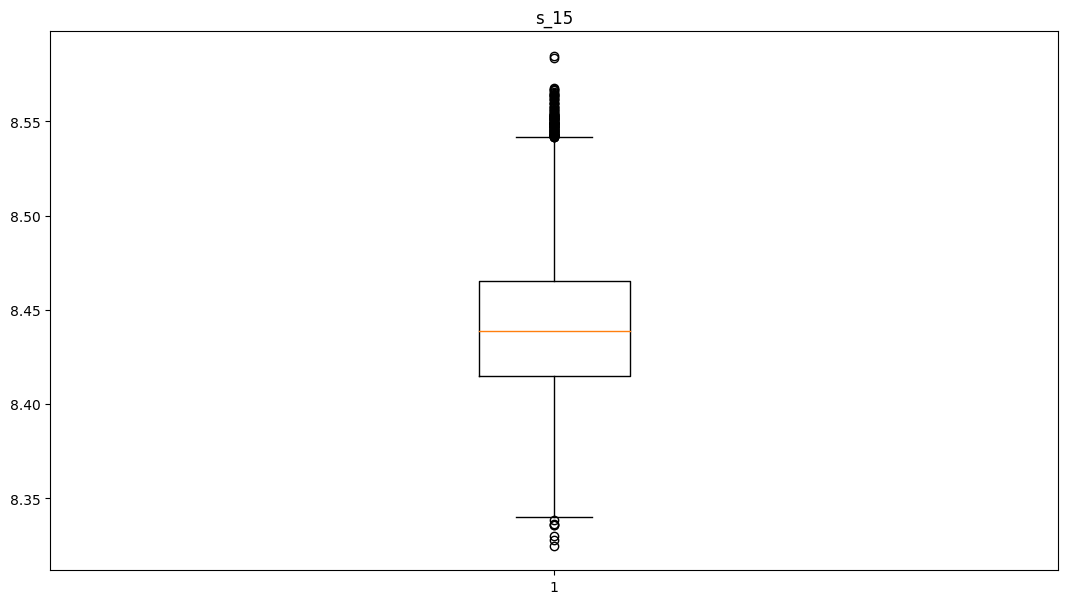

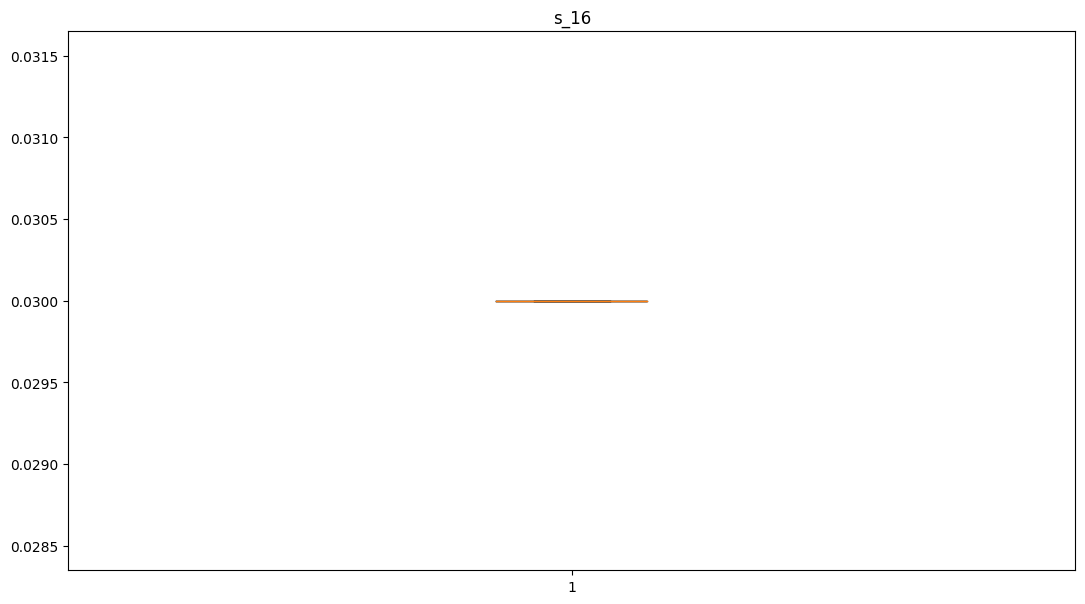

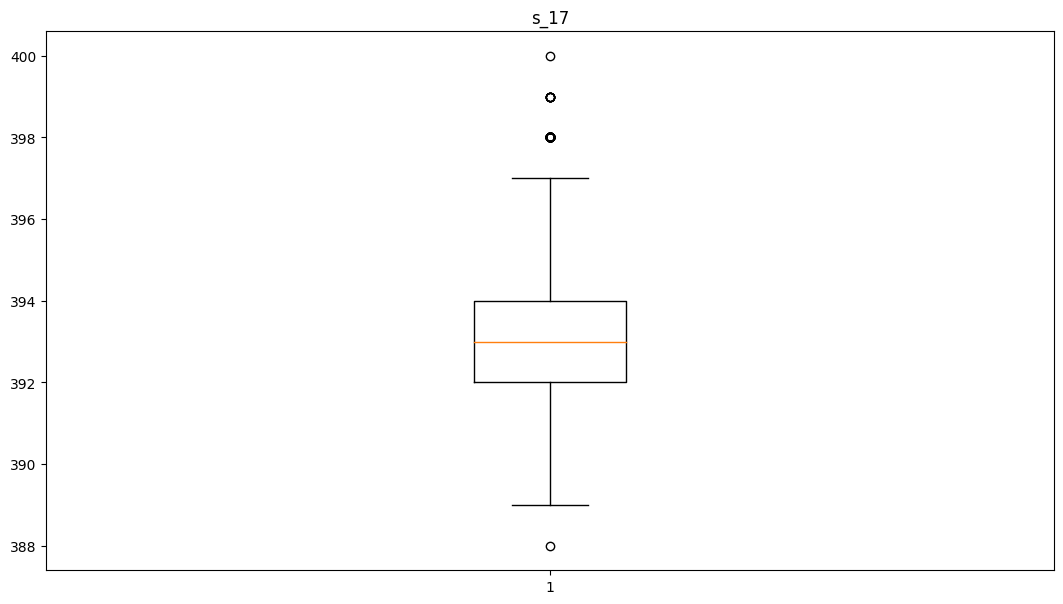

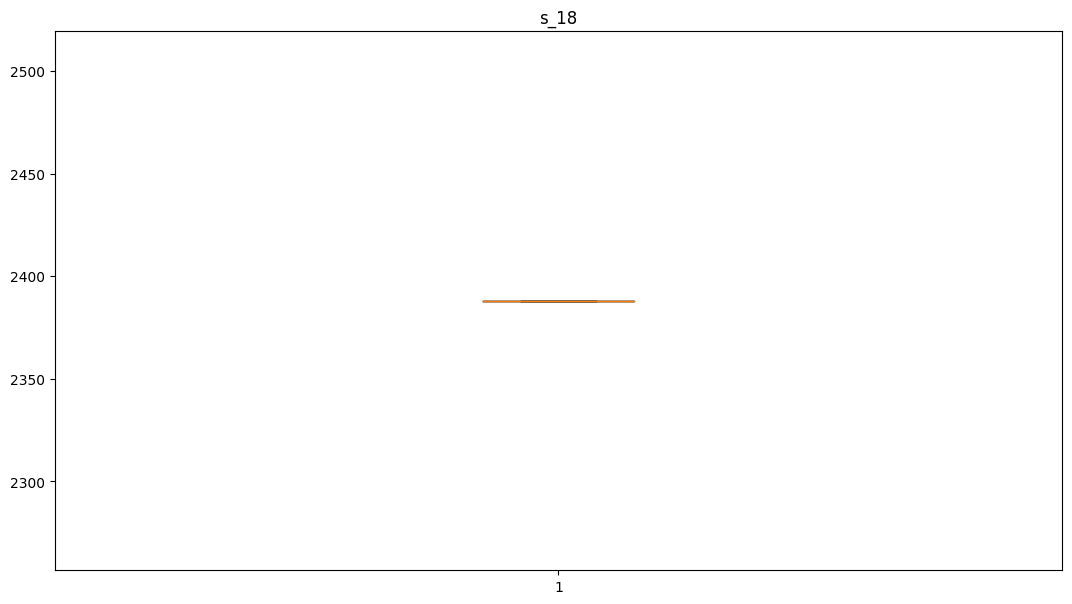

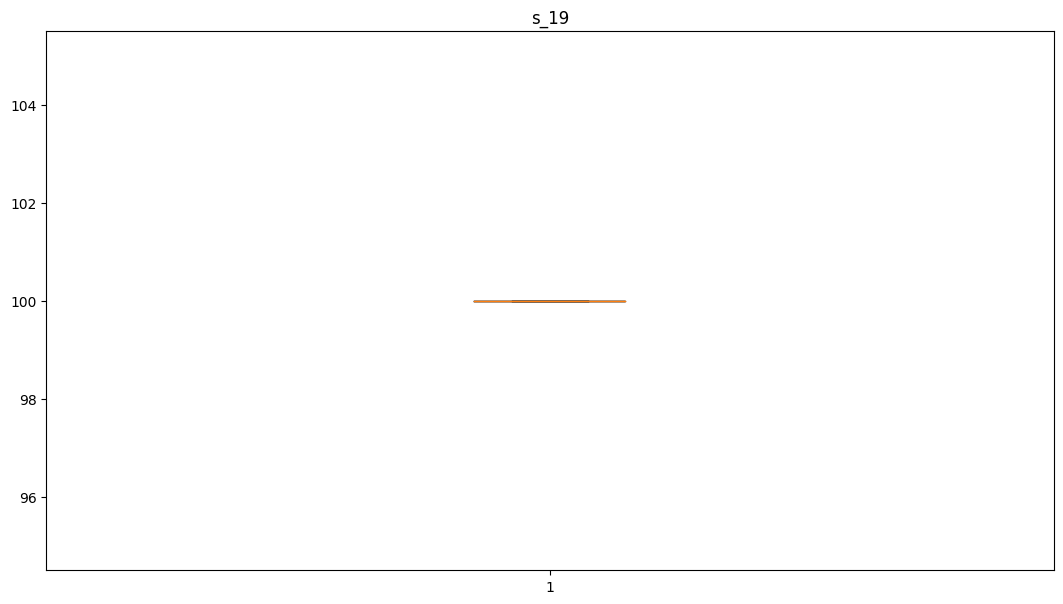

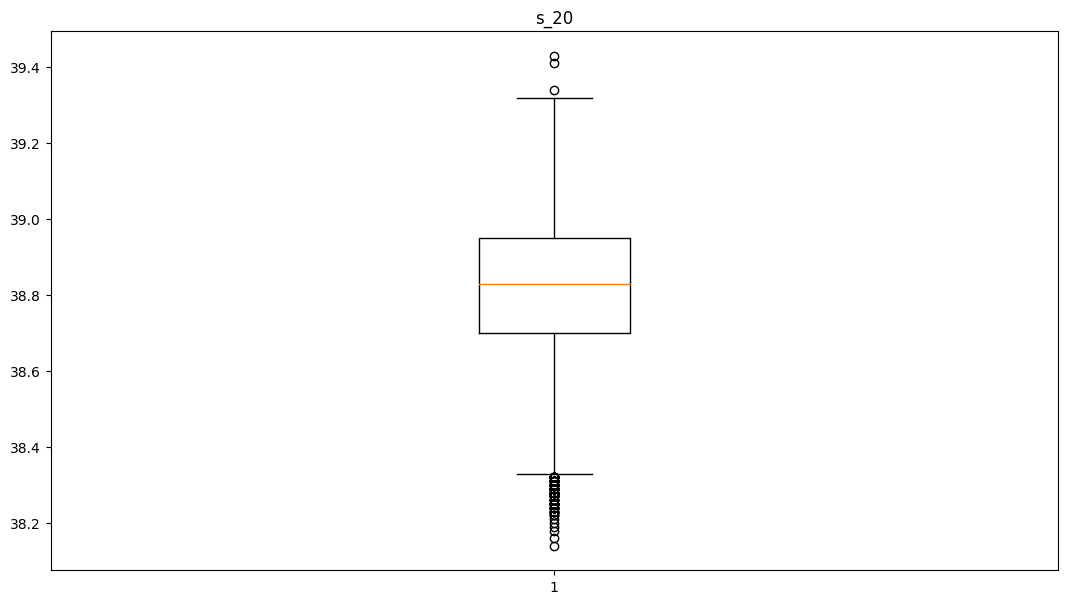

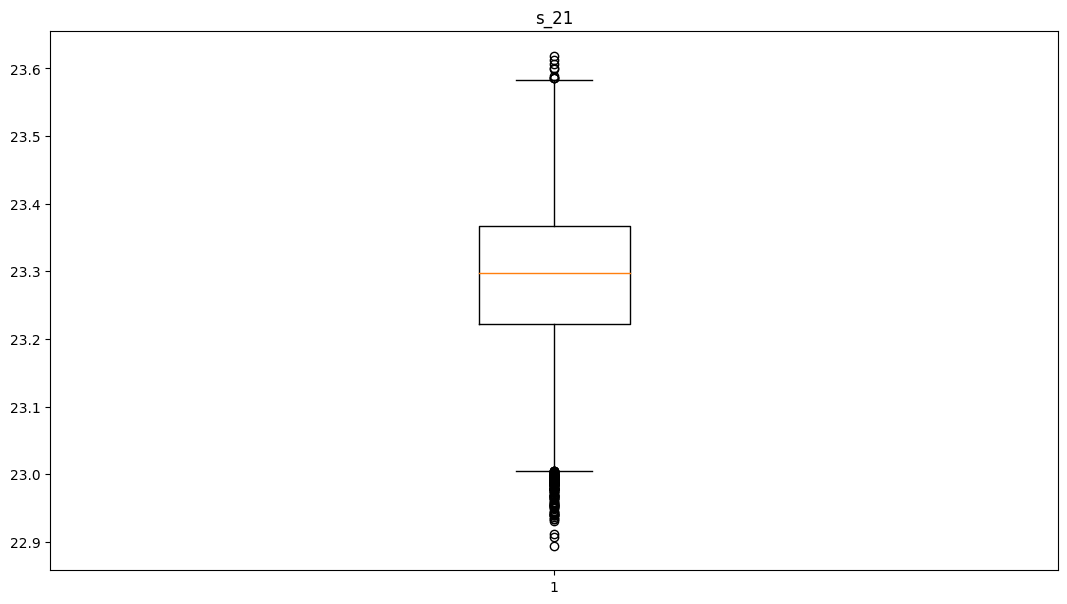

In [23]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

Observing the signal plots and the boxplots, we notice that the sensors 1,5,10,16,18,19 are constant, furthermore, we observe that the other sensors aren't well distributed and there are many outliers, then we should scale our data

In [24]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  0.000000e+00     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.387812e-17     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   
RUL   20631.0   107.807862  6.888099e+01     0.0000    51.0000   103.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184  
RUL    155.0000   361.0000

 The last point is more supported by the fact that the statistic properties of sensors data show that they don't have the same scale and they don't follow a normal distribution ==> this can be solved by performing a Minmax scaler on our data.

### **Dimensionality Reduction**
##### Dropping unnecessary features (labels and settings)

In [25]:
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42)

In [26]:
X_train

s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
12862  518.67  643.08  1592.07  1402.73  14.62  21.61  554.10  2388.09   
9936   518.67  642.21  1580.72  1394.09  14.62  21.61  553.34  2387.99   
12025  518.67  642.09  1586.25  1404.03  14.62  21.61  554.27  2388.06   
14526  518.67  643.52  1597.95  1423.87  14.62  21.61  552.22  2388.21   
16747  518.67  642.34  1586.62  1401.82  14.62  21.61  554.13  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
11284  518.67  642.19  1592.99  1390.35  14.62  21.61  553.93  2388.06   
11964  518.67  641.81  1580.59  1404.09  14.62  21.61  554.78  2388.01   
5390   518.67  642.50  1600.91  1415.54  14.62  21.61  553.50  2388.09   
860    518.67  641.93  1578.03  1396.28  14.62  21.61  554.52  2387.97   
15795  518.67  642.17  1590.60  1401.35  14.62  21.61  554.01  2388.02   

           s_9  s_10  ...     s_13     s_14    s_15  s_16  s_17  s_18   s_19  \
12862  9062.50   1.3  ...  2388.04  8133.34  8.4301  0.03   393  2388  100.0   
9936   9066.77   1.3  ...  2388.03  8144.06  8.3837  0.03   392  2388  100.0   
12025  9061.07   1.3  ...  2388.01  8139.32  8.4244  0.03   391  2388  100.0   
14526  9031.18   1.3  ...  2388.16  8109.80  8.4930  0.03   394  2388  100.0   
16747  9054.55   1.3  ...  2388.03  8128.29  8.4081  0.03   392  2388  100.0   
...        ...   ...  ...      ...      ...     ...   ...   ...   ...    ...   
11284  9039.80   1.3  ...  2388.07  8133.16  8.4340  0.03   393  2388  100.0   
11964  9065.90   1.3  ...  2387.98  8145.57  8.3866  0.03   390  2388  100.0   
5390   9061.03   1.3  ...  2388.08  8150.90  8.3974  0.03   392  2388  100.0   
860    9062.88   1.3  ...  2388.03  8153.40  8.4214  0.03   393  2388  100.0   
15795  9055.63   1.3  ...  2387.96  8139.49  8.3522  0.03   391  2388  100.0   

        s_20     s_21  RUL  
12862  38.67  23.3724   54  
9936   39.08  23.3686  185  
12025  38.96  23.3025  101  
14526  38.54  23.1882   24  
16747  39.08  23.4485  137  
...      ...      ...  ...  
11284  38.95  23.2258  107  
11964  38.93  23.4079  162  
5390   38.75  23.3561   74  
860    39.07  23.3733  255  
15795  39.16  23.4062  157  

[14441 rows x 22 columns]

In [27]:
y_train

12862     54
9936     185
12025    101
14526     24
16747    137
        ... 
11284    107
11964    162
5390      74
860      255
15795    157
Name: RUL, Length: 14441, dtype: int64

### **Scaling the data: Min - Max Scaler**

**MinMax scaler function** :Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set

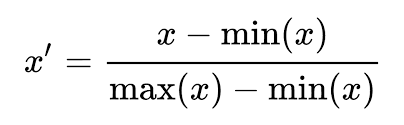

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Tester = X_test.copy()
Trainer = X_train.copy()

#Droping the target variable
X_train.drop(columns=['RUL','s_1','s_5','s_6','s_10','s_16','s_18','s_19'], inplace=True)
X_test.drop(columns=['RUL','s_1','s_5','s_6','s_10','s_16','s_18','s_19'], inplace=True)
#Scaling X_train and X_test
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)
#Conserve only the last occurence of each unit to match the length of y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
Validator = X_valid.copy()
X_valid.drop(columns=['s_1','s_5','s_6','s_10','s_16','s_18','s_19'], inplace=True)
#scaling X_valid
X_valid_s=scaler.fit_transform(X_valid)


Grouping by 'unit_number' and Taking the Last Observation:

* X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
* valid.groupby('unit_number').last(): Groups the 'valid' DataFrame by 'unit_number' and selects the last observation within each group.
* reset_index(): Resets the index of the resulting DataFrame.
* drop(columns=drop_labels): Drops specified columns from the DataFrame.

Scaling X_valid:

* X_valid_s = scaler.fit_transform(X_valid)
* scaler.fit_transform(X_valid): Uses the fit_transform method of a scaler to scale the features in X_valid. This involves computing the mean and standard deviation from the training data (X_train) and then applying the transformation to the validation data.
It's important to note that the fit_transform method should be used with the same scaler that was fitted on the training data (X_train). This ensures that the same scaling parameters are applied to both the training and validation datasets, maintaining consistency.

In [29]:
X_valid

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12  \
0   642.58  1581.22  1398.91  554.42  2388.08  9056.40  47.23  521.79   
1   642.55  1586.59  1410.83  553.52  2388.10  9044.77  47.67  521.74   
2   642.88  1589.75  1418.89  552.59  2388.16  9049.26  47.88  520.83   
3   642.78  1594.53  1406.88  552.64  2388.13  9051.30  47.65  521.88   
4   642.27  1589.94  1419.36  553.29  2388.10  9053.99  47.46  521.00   
..     ...      ...      ...     ...      ...      ...    ...     ...   
95  642.30  1590.88  1397.94  553.99  2388.03  9062.41  47.14  522.30   
96  642.59  1582.96  1410.92  554.05  2388.06  9076.36  47.38  521.58   
97  642.68  1599.51  1415.47  553.44  2388.13  9062.34  47.66  521.53   
98  642.00  1585.03  1397.98  554.75  2388.01  9067.16  47.26  521.82   
99  642.95  1601.62  1424.99  552.48  2388.06  9155.03  47.80  521.07   

       s_13     s_14    s_15  s_17   s_20     s_21  
0   2388.06  8130.11  8.4024   393  38.81  23.3552  
1   2388.09  8126.90  8.4505   391  38.81  23.2618  
2   2388.14  8131.46  8.4119   395  38.93  23.2740  
3   2388.11  8133.64  8.4634   395  38.58  23.2581  
4   2388.15  8125.74  8.4362   394  38.75  23.4117  
..      ...      ...     ...   ...    ...      ...  
95  2388.01  8148.24  8.4110   391  38.96  23.4606  
96  2388.06  8155.48  8.4500   395  38.61  23.2953  
97  2388.09  8146.39  8.4235   394  38.76  23.3608  
98  2388.02  8150.38  8.4003   391  38.95  23.3595  
99  2388.05  8214.64  8.4903   396  38.70  23.1855  

[100 rows x 14 columns]

In [30]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 14)
(100, 1)


#### plotting features new distribution

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

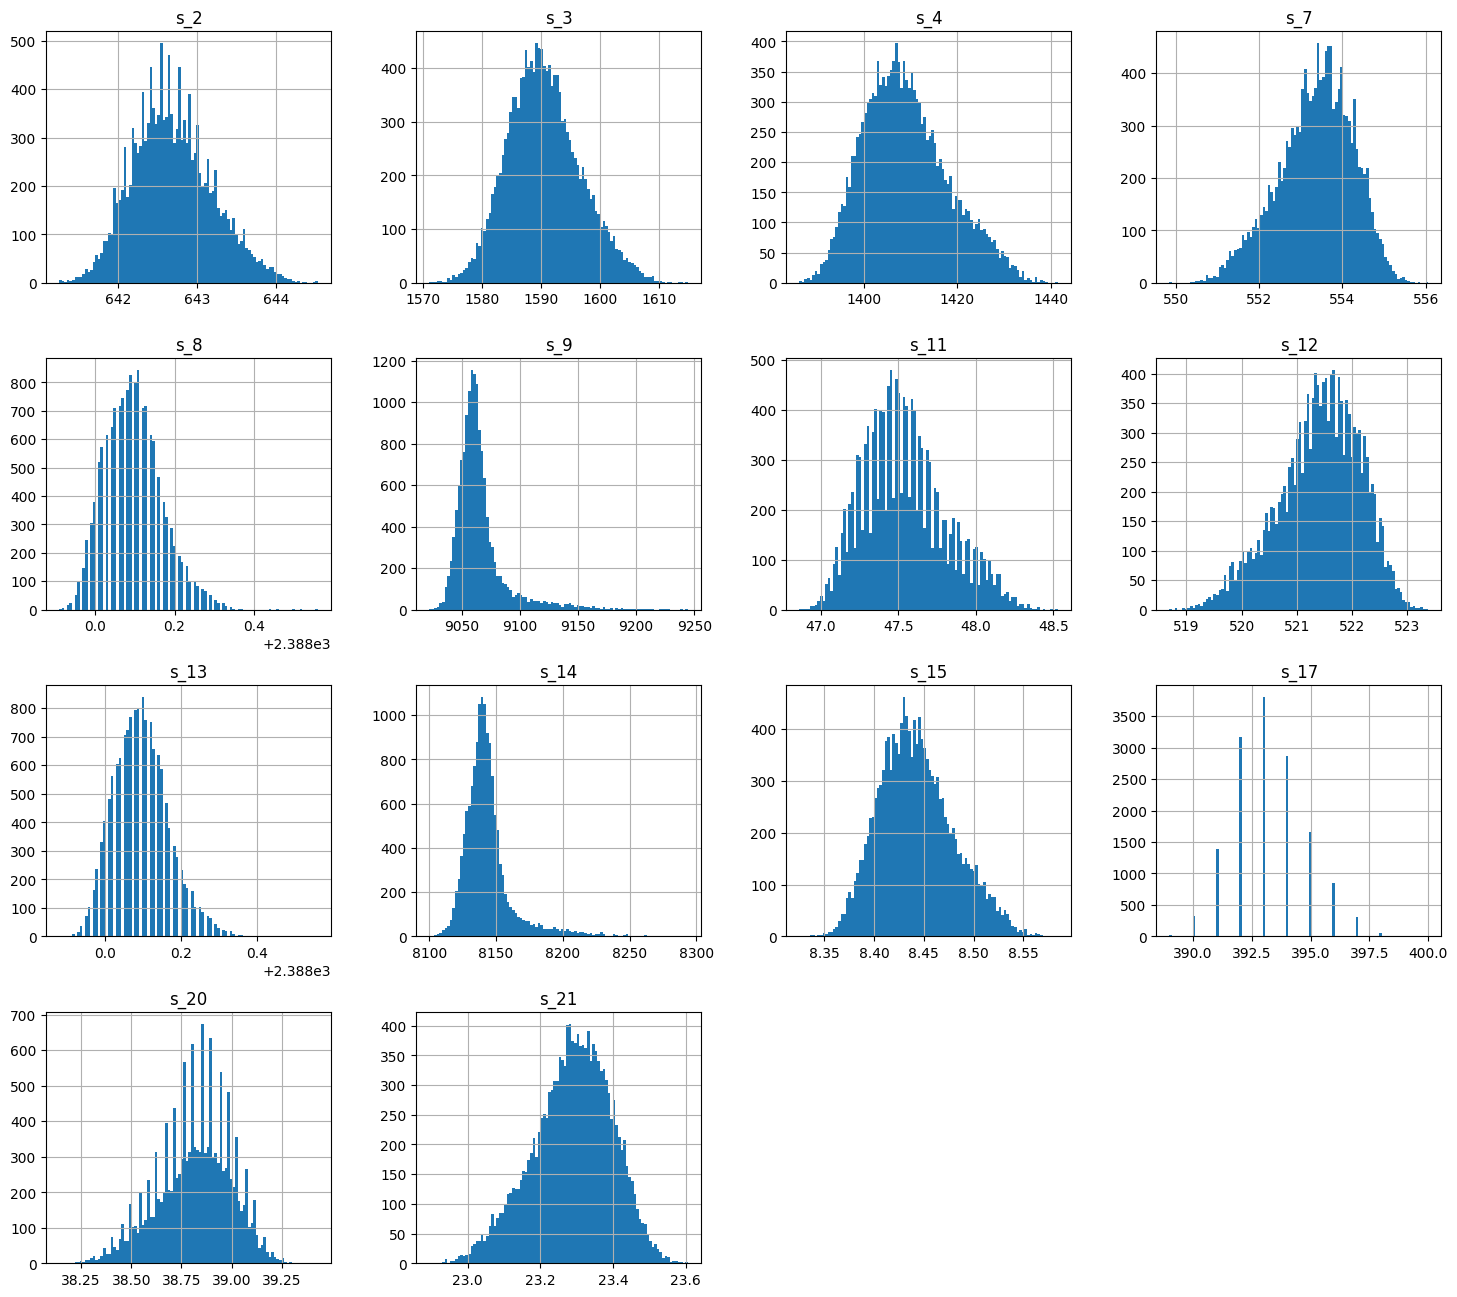

In [31]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(Trainer,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

In [32]:
len(X_train)

14441

In [33]:
len(X_test)

6190

In [34]:
len(y_train)

14441

In [35]:
len(y_test)

6190

In [36]:
len(X_train_s)

14441

In [37]:
y_train

12862     54
9936     185
12025    101
14526     24
16747    137
        ... 
11284    107
11964    162
5390      74
860      255
15795    157
Name: RUL, Length: 14441, dtype: int64

In [38]:
X_train

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12  \
12862  643.08  1592.07  1402.73  554.10  2388.09  9062.50  47.67  521.78   
9936   642.21  1580.72  1394.09  553.34  2387.99  9066.77  47.21  522.67   
12025  642.09  1586.25  1404.03  554.27  2388.06  9061.07  47.22  521.70   
14526  643.52  1597.95  1423.87  552.22  2388.21  9031.18  47.94  520.08   
16747  642.34  1586.62  1401.82  554.13  2388.06  9054.55  47.22  522.24   
...       ...      ...      ...     ...      ...      ...    ...     ...   
11284  642.19  1592.99  1390.35  553.93  2388.06  9039.80  47.28  521.74   
11964  641.81  1580.59  1404.09  554.78  2388.01  9065.90  47.27  523.13   
5390   642.50  1600.91  1415.54  553.50  2388.09  9061.03  47.48  521.68   
860    641.93  1578.03  1396.28  554.52  2387.97  9062.88  47.26  522.19   
15795  642.17  1590.60  1401.35  554.01  2388.02  9055.63  47.12  521.91   

          s_13     s_14    s_15  s_17   s_20     s_21  
12862  2388.04  8133.34  8.4301   393  38.67  23.3724  
9936   2388.03  8144.06  8.3837   392  39.08  23.3686  
12025  2388.01  8139.32  8.4244   391  38.96  23.3025  
14526  2388.16  8109.80  8.4930   394  38.54  23.1882  
16747  2388.03  8128.29  8.4081   392  39.08  23.4485  
...        ...      ...     ...   ...    ...      ...  
11284  2388.07  8133.16  8.4340   393  38.95  23.2258  
11964  2387.98  8145.57  8.3866   390  38.93  23.4079  
5390   2388.08  8150.90  8.3974   392  38.75  23.3561  
860    2388.03  8153.40  8.4214   393  39.07  23.3733  
15795  2387.96  8139.49  8.3522   391  39.16  23.4062  

[14441 rows x 14 columns]

In [39]:
X_train_s

array([[0.55792683, 0.47915243, 0.29782609, ..., 0.36363636, 0.41085271,
        0.67144061],
       [0.29268293, 0.22055138, 0.14130435, ..., 0.27272727, 0.72868217,
        0.66610503],
       [0.25609756, 0.34654819, 0.32137681, ..., 0.18181818, 0.63565891,
        0.57329402],
       ...,
       [0.38109756, 0.68056505, 0.5298913 , ..., 0.27272727, 0.47286822,
        0.64855378],
       [0.20731707, 0.15926179, 0.18097826, ..., 0.36363636, 0.72093023,
        0.6727043 ],
       [0.2804878 , 0.4456596 , 0.27282609, ..., 0.18181818, 0.79069767,
        0.71889919]])

## **Models Implementation and instantiation**

#### Defining evaluation functions

In [40]:
#R2 score & RMSE & MAER
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

### **1) Random forest**

i.e., Random forest regressor

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = {
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_s, y_train)

print(grid.best_score_ , grid.best_params_)
#max_features=5,

0.641561944804369 {'max_depth': 9, 'n_estimators': 120}


==> the model is overfitting to train/test

In [42]:
rf=RandomForestRegressor(n_estimators=90,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_s, y_train)
# predict and evaluate
y_hat_train = rf.predict(X_train_s)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_s)
evaluate(y_test, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:35.17174929044478, R2:0.7430304746805648
test set RMSE:44.12656814856002, R2:0.5748919872018761
valid set RMSE:34.742754209743154, R2:0.301013249594164


==> the model is overfitting to train/test

In [43]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

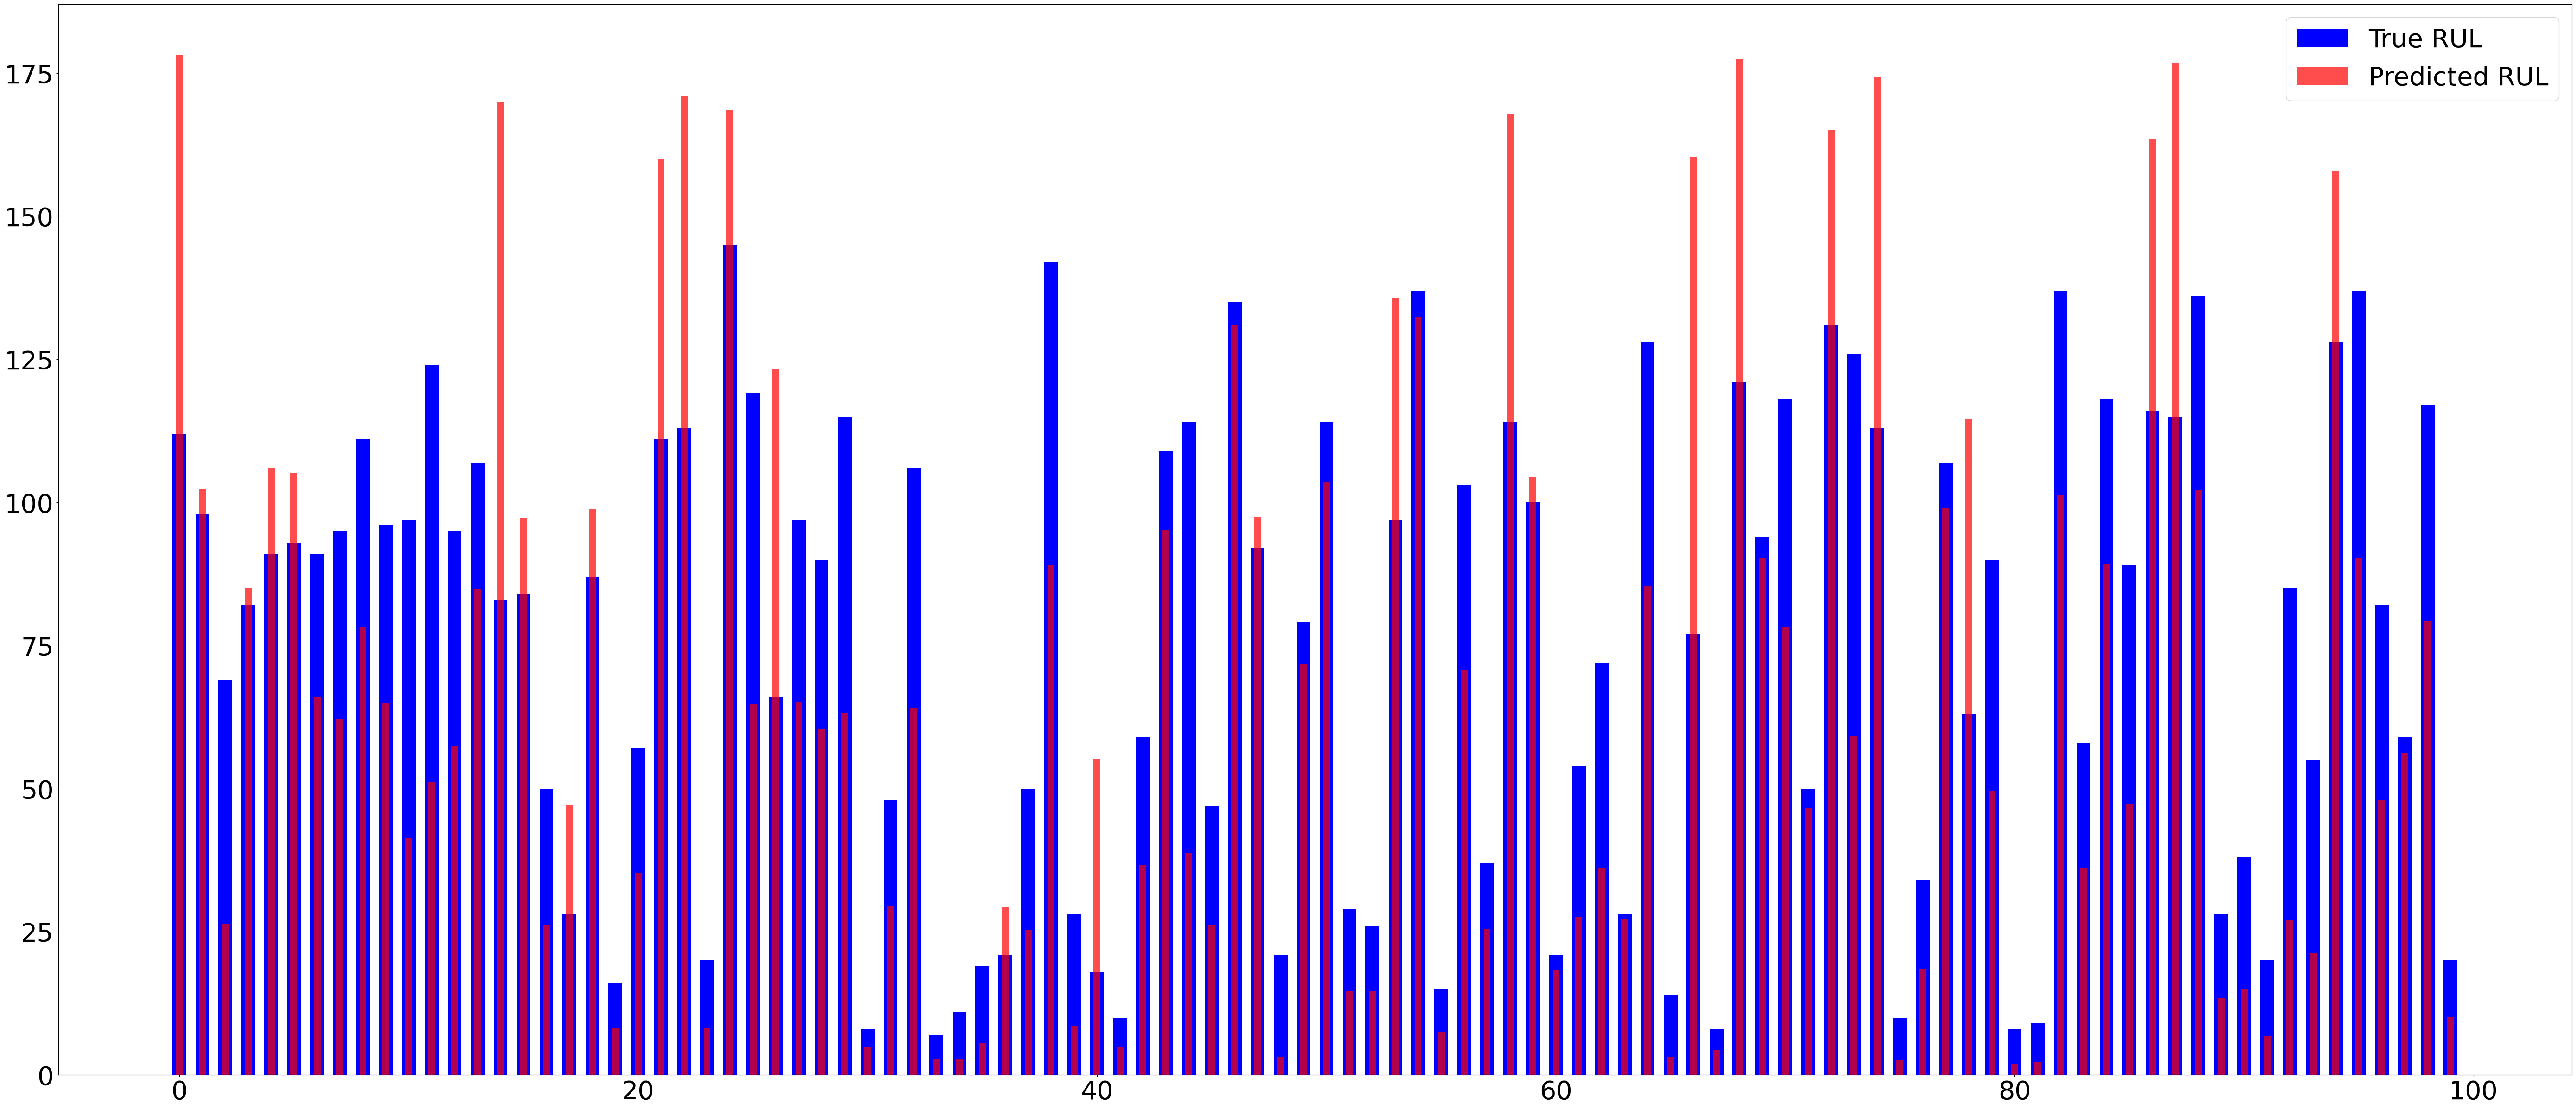

In [44]:
plot_predActual(y_valid, y_hat_valid)

In [45]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_test : ',y_test.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  361
maximum of y_test :  360
maximum of y_valid :  RUL    145
dtype: int64


==> the model is overfitting to train/test

### **2) SUPPORT VECTOR REGRESSION (SVR)**

In [46]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train_s, y_train)
# predict and evaluate
y_hat_train = regressor.predict(X_train_s)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = regressor.predict(X_test_s)
evaluate(y_test, y_hat_test, label='test')
y_hat_valid = regressor.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:42.54724224579233, R2:0.6239578590036827
test set RMSE:48.75516379159361, R2:0.48103242301470384
valid set RMSE:25.947912225366206, R2:0.6101071274546097


In [47]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

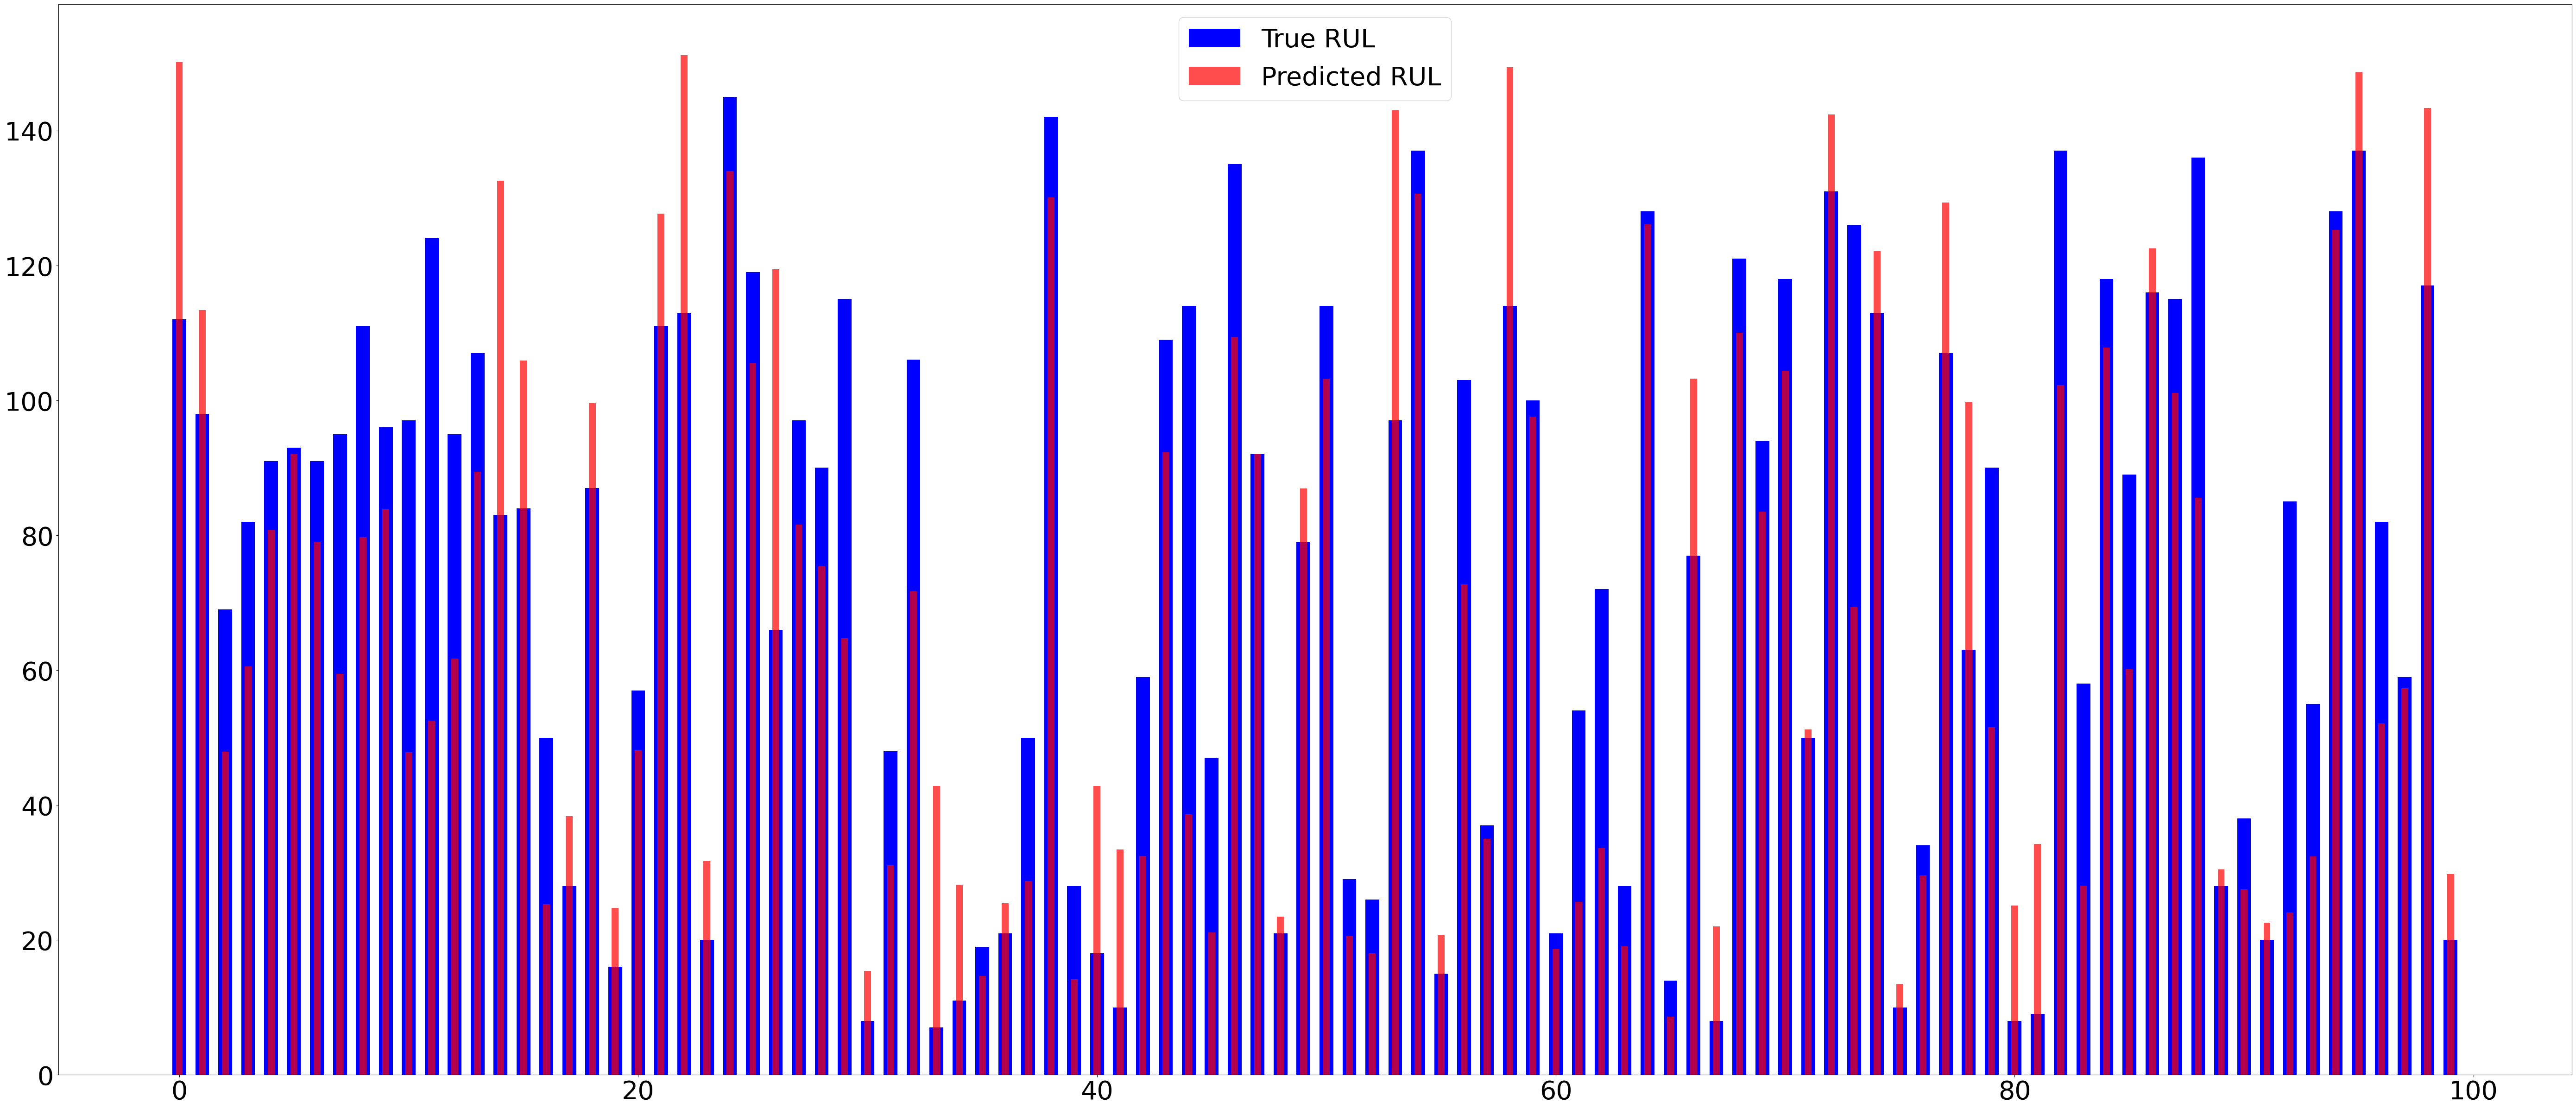

In [48]:
plot_predActual(y_valid, y_hat_valid)

### **3) Linear Regression**

In [49]:
from sklearn.linear_model import LinearRegression

# Create the model
model = LinearRegression()

# Train the model
model.fit(X_train_s,y_train)

# predict and evaluate
y_hat_train = model.predict(X_train_s)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = model.predict(X_test_s)
evaluate(y_test, y_hat_test, label='test')
y_hat_valid = model.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:44.803728035551984, R2:0.5830135052284944
test set RMSE:46.11402576435105, R2:0.53573594329478
valid set RMSE:43.05877886885163, R2:-0.0736528326612873


In [50]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

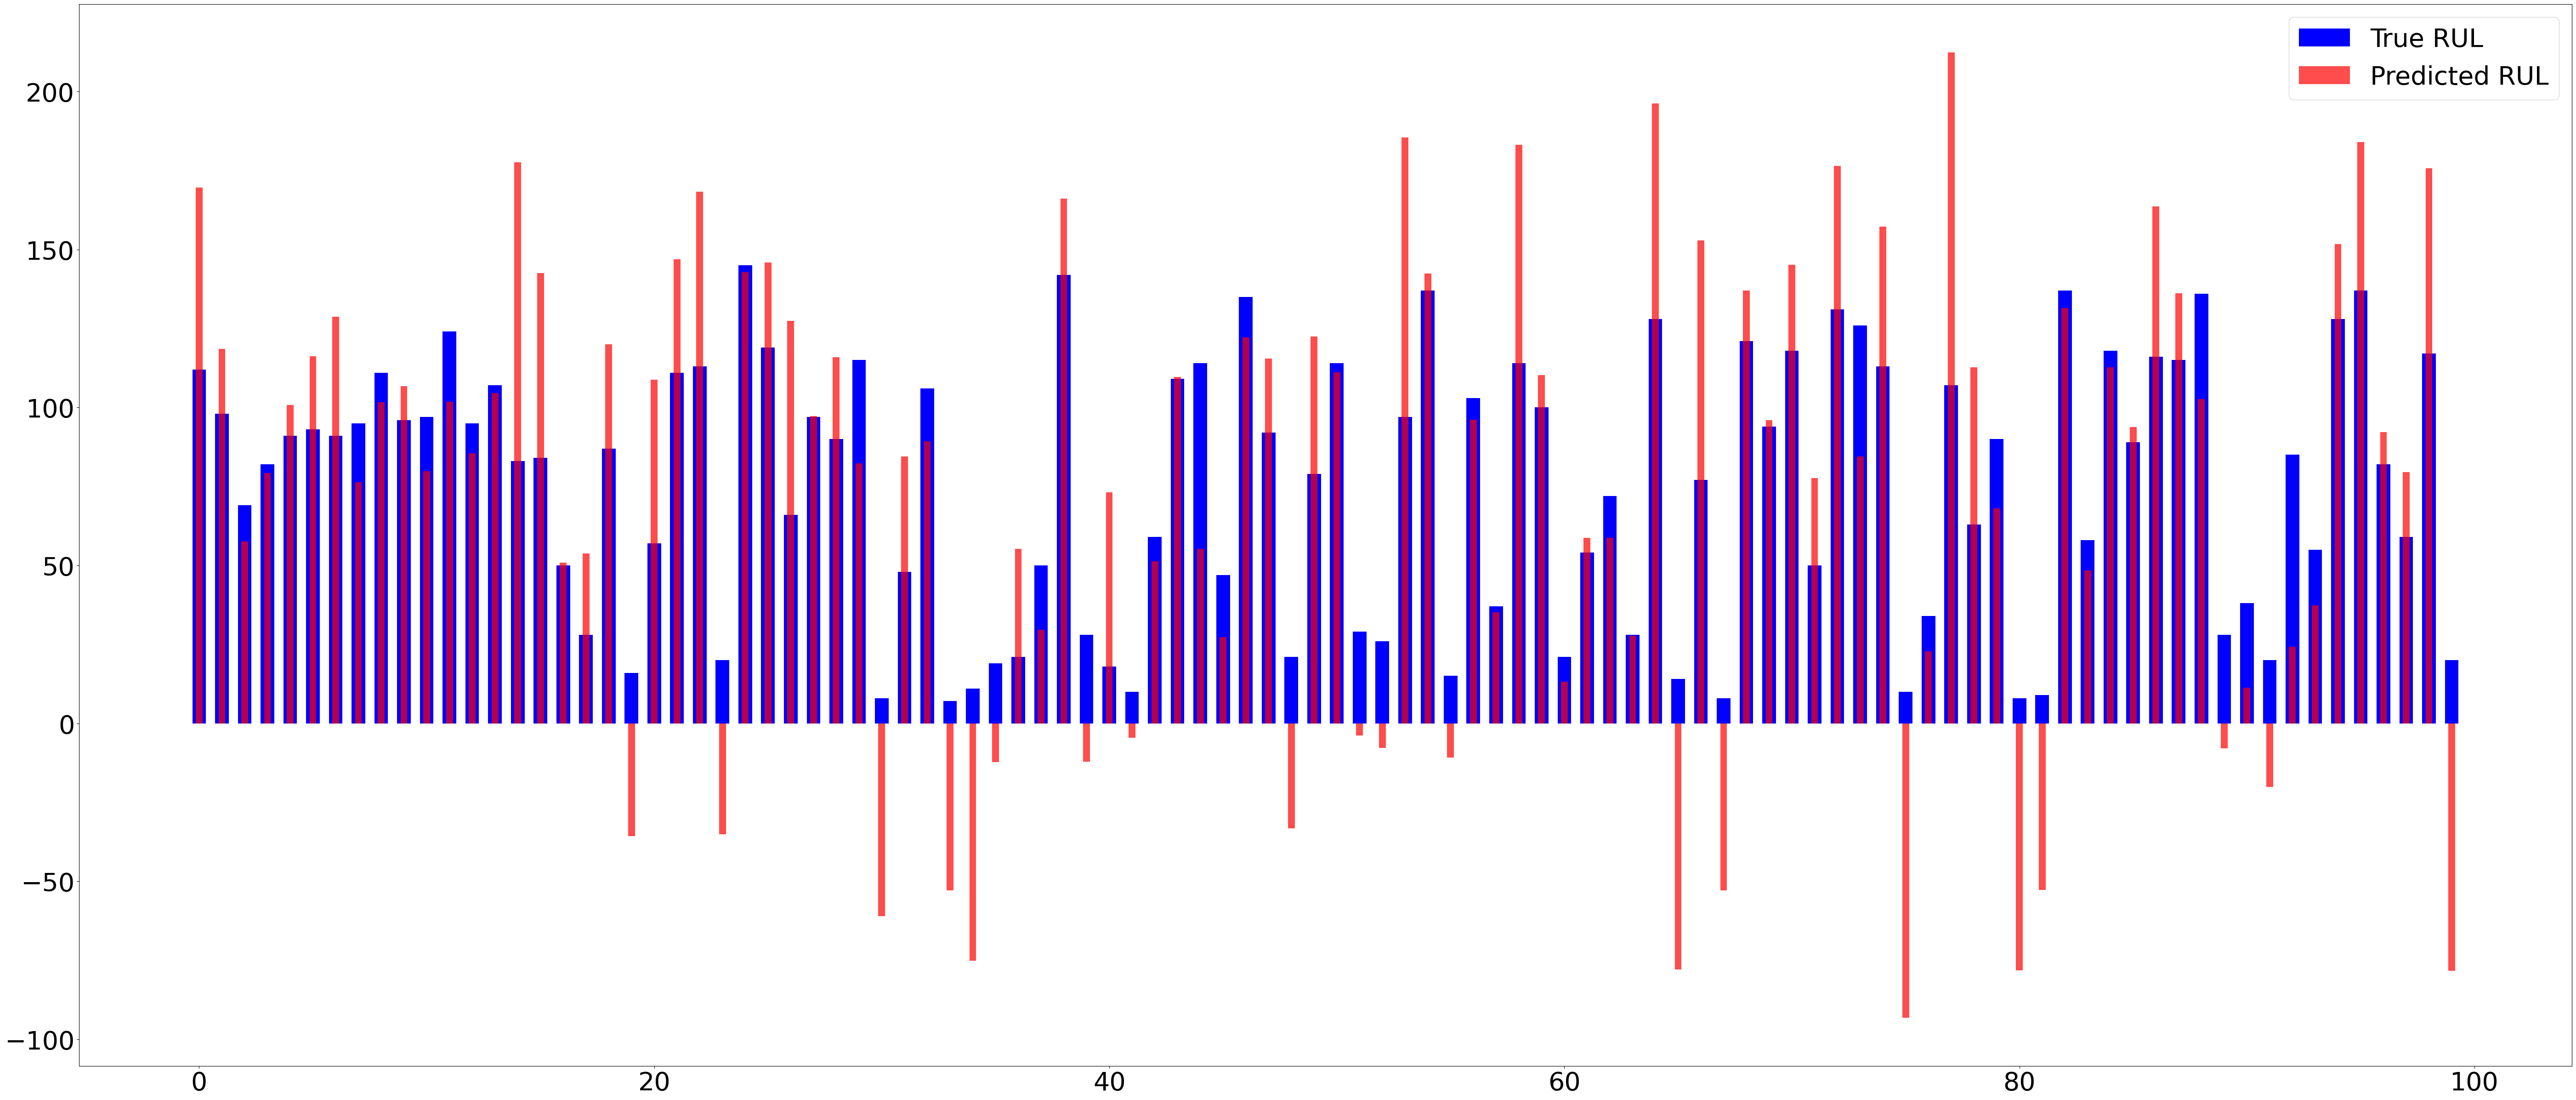

In [51]:
plot_predActual(y_valid, y_hat_valid)

### **Feature importance**

<BarContainer object of 14 artists>

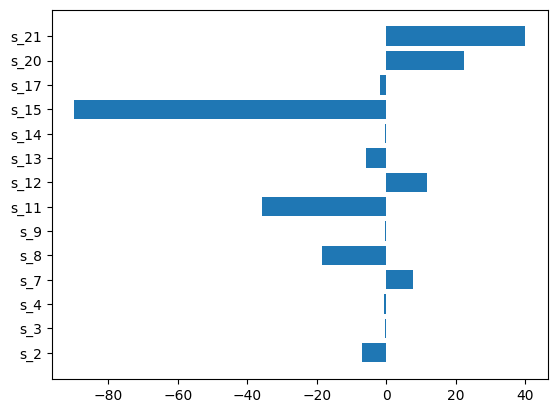

In [52]:
#BEST FEATURE FOR LINEAR REGRESSION MODEL

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=X_train, y=y_train)
plt.barh(X_train.columns, model.coef_)

<BarContainer object of 14 artists>

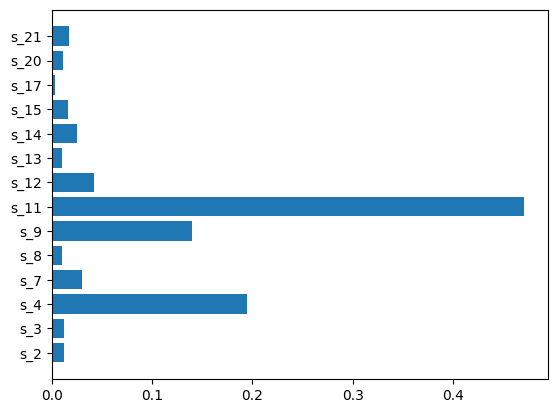

In [53]:
#BEST FEATURE FOR RANDOM FOREST i.e., RF MODEL
rf.fit(X_train, y_train)
plt.barh(X_train.columns, rf.feature_importances_)

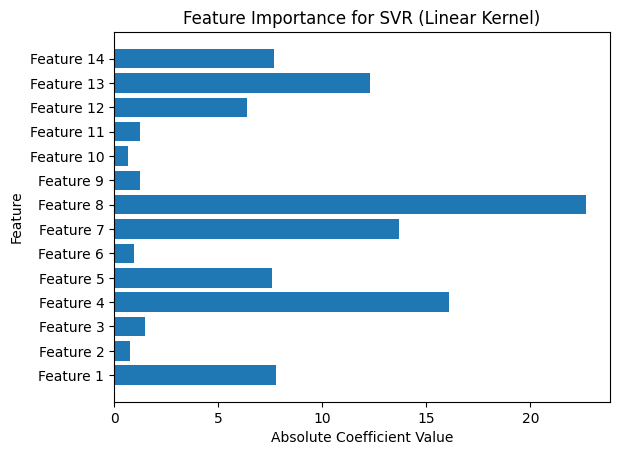

In [54]:
#BEST FEATURE FOR SUPPORT VECTOR REGRESSION (SVR)
from sklearn.svm import SVR

# Assuming X_train is your feature matrix and y_train is your target variable
regressor = SVR(kernel='linear')
regressor.fit(X_train, y_train)

# Get coefficients
coefficients = regressor.coef_[0]  # Extract the coefficients from the array

# Plot feature importance
plt.barh(range(X_train.shape[1]), np.abs(coefficients))
plt.yticks(range(X_train.shape[1]), [f'Feature {i}' for i in range(1, X_train.shape[1] + 1)])
plt.title('Feature Importance for SVR (Linear Kernel)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()


#### Creating new df

i.e., removing common less important features(w.r.to all algorithms) in train, test and valid sets

In [55]:
X_train.drop(columns=['s_3','s_17'], inplace=True)
X_test.drop(columns=['s_3','s_17'], inplace=True)
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)
X_valid.drop(columns=['s_3','s_17'], inplace=True)
X_valid_s=scaler.fit_transform(X_valid)

In [56]:
from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor(n_estimators=200,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_s, y_train)
# predict and evaluate
y_hat_train = rf.predict(X_train_s)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_s)
evaluate(y_test, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:35.29518350643536, R2:0.7412236558168778
test set RMSE:44.226283822594795, R2:0.5729685279592203
valid set RMSE:35.11259711275048, R2:0.2860523597135919


What we are seeing here is that sensors s_9, s_11, s_12 et s_7 have a significant effect on RUL.
For instance, if keep all other features constant, we notice that when the Physical core speed (represented by s_9) increases , the RUL is comparatively decreasing.

In [57]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

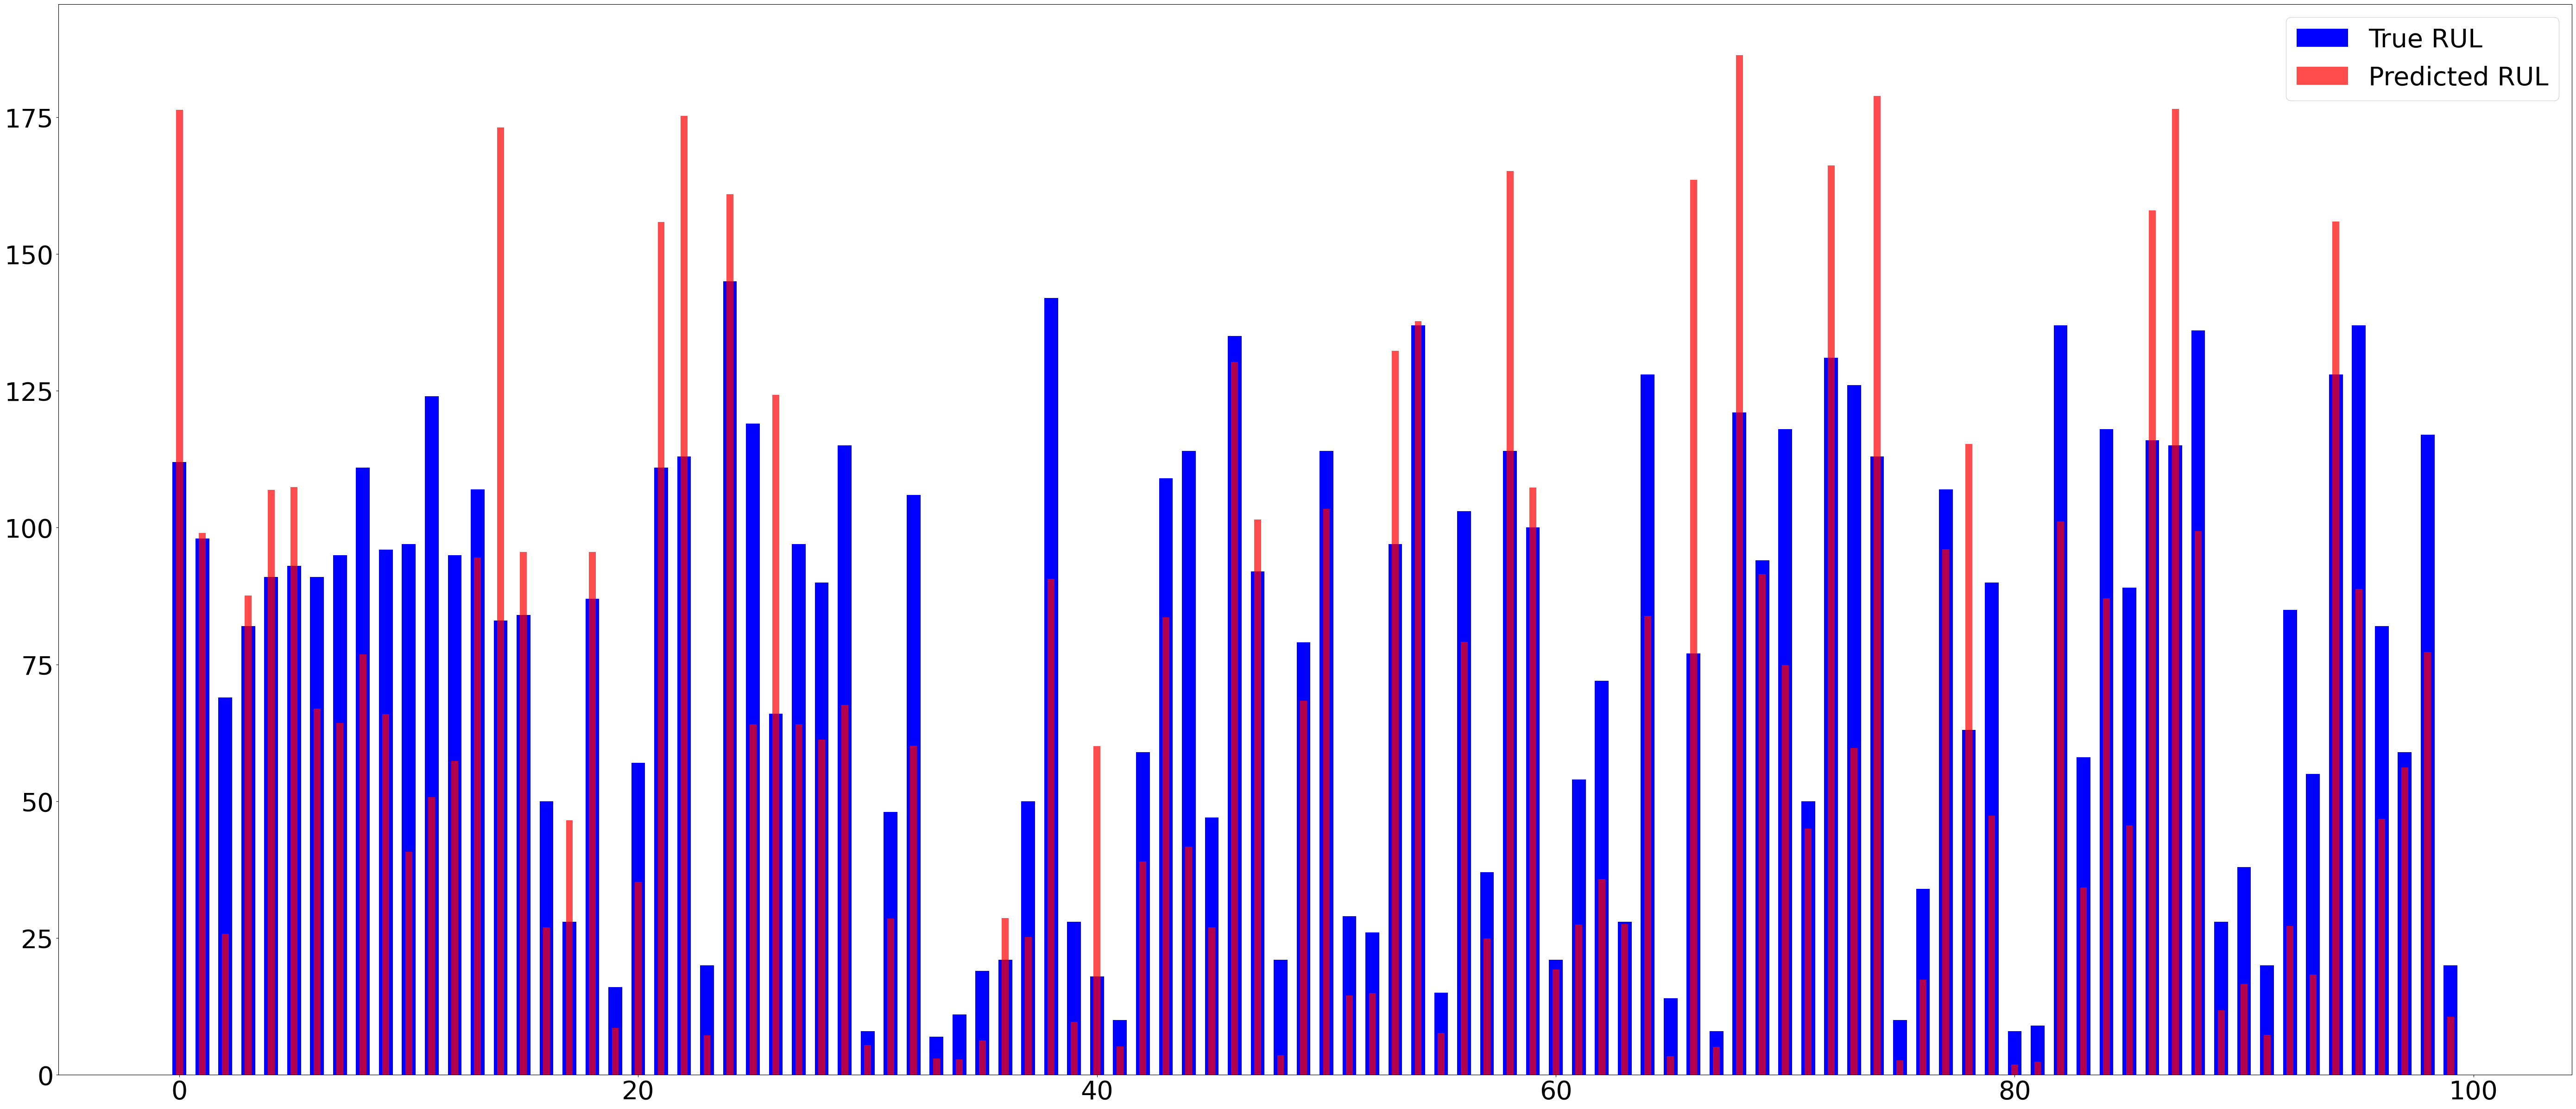

In [58]:
plot_predActual(y_valid, y_hat_valid)

#### **Removing less important features**

In [59]:
#### Creating new df for rf
Train_rf = X_train.copy()
Test_rf = X_test.copy()
Valid_rf = X_valid.copy()
Train_rf.drop(columns=['s_2','s_13','s_8','s_20'], inplace=True)
Test_rf.drop(columns=['s_2','s_13','s_8','s_20'], inplace=True)
Train_rf_s=scaler.fit_transform(Train_rf)
Test_rf_s=scaler.fit_transform(Test_rf)
Valid_rf.drop(columns=['s_2','s_13','s_8','s_20'], inplace=True)
Valid_rf_s=scaler.fit_transform(Valid_rf)

from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor(n_estimators=200,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(Train_rf_s, y_train)
# predict and evaluate
y_hat_train = rf.predict(Train_rf_s)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(Test_rf_s)
evaluate(y_test, y_hat_test, label='test')
y_hat_valid = rf.predict(Valid_rf_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:35.938695300356585, R2:0.7317014670067755
test set RMSE:43.29195832822784, R2:0.590820893531979
valid set RMSE:35.34143520086585, R2:0.2767160635307957


Removing less contributing features for the random forest regressor and evaluating the model. Overfitting happens again.

#### Feature Importance

<BarContainer object of 22 artists>

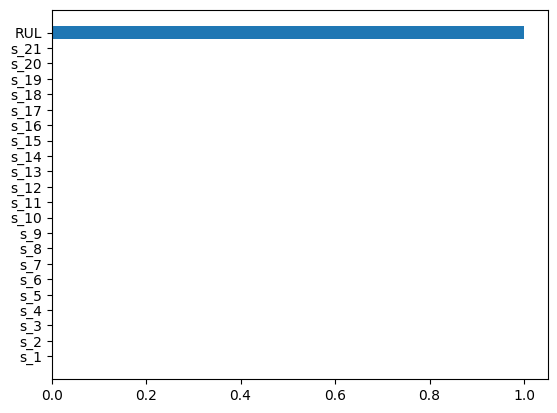

In [60]:
#BEST FEATURE FOR RF MODEL
rf.fit(Trainer, y_train)
plt.barh(Trainer.columns, rf.feature_importances_)

<BarContainer object of 22 artists>

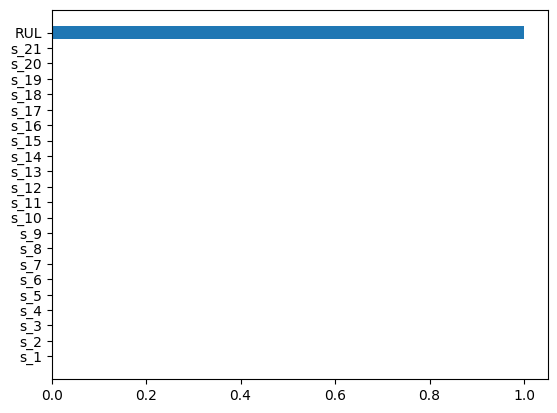

In [61]:
#BEST FEATURE FOR LINEAR REGRESSION MODEL

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=Trainer, y=y_train)
plt.barh(Trainer.columns, model.coef_)

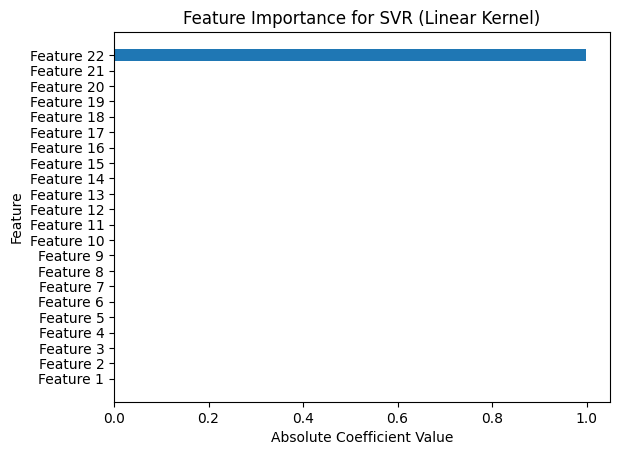

In [62]:
from sklearn.svm import SVR

# Assuming Trainer is your feature matrix and y_train is your target variable
regressor = SVR(kernel='linear')
regressor.fit(Trainer, y_train)

# Get coefficients
coefficients = regressor.coef_[0]  # Extract the coefficients from the array

# Plot feature importance
plt.barh(range(Trainer.shape[1]), np.abs(coefficients))
plt.yticks(range(Trainer.shape[1]), [f'Feature {i}' for i in range(1, Trainer.shape[1] + 1)])
plt.title('Feature Importance for SVR (Linear Kernel)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

<BarContainer object of 21 artists>

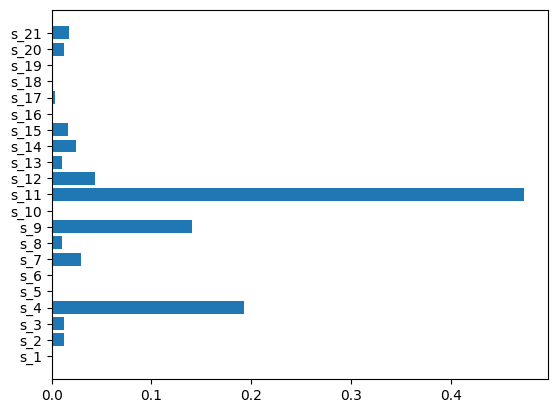

In [63]:
Trainer.drop(columns=['RUL'], inplace=True)
#BEST FEATURE FOR RF MODEL
rf.fit(Trainer, y_train)
plt.barh(Trainer.columns, rf.feature_importances_)

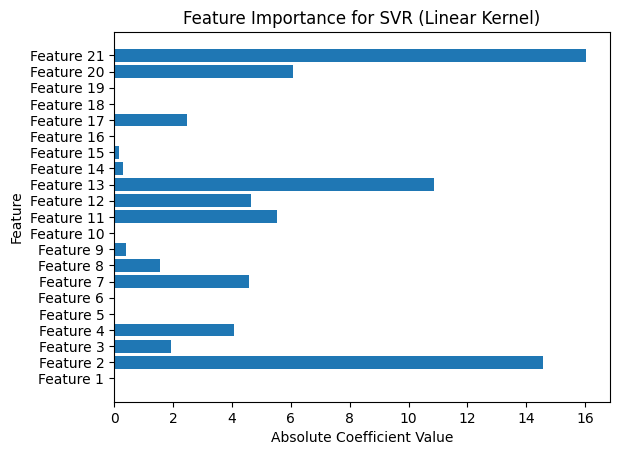

In [64]:
from sklearn.svm import SVR

# Assuming Trainer is your feature matrix and y_train is your target variable
regressor = SVR(kernel='linear')
regressor.fit(Trainer, y_train)

# Get coefficients
coefficients = regressor.coef_[0]  # Extract the coefficients from the array

# Plot feature importance
plt.barh(range(Trainer.shape[1]), np.abs(coefficients))
plt.yticks(range(Trainer.shape[1]), [f'Feature {i}' for i in range(1, Trainer.shape[1] + 1)])
plt.title('Feature Importance for SVR (Linear Kernel)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

Features having constant values has 0 importance.

### **Best Model**

#### **Taking best fit using max_features ="sqrt"** and train, test using random forest regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_s, y_train)
# predict and evaluate
y_hat_train = rf.predict(X_train_s)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_s)
evaluate(y_test, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:15.532135723357555, R2:0.9498863496611952
test set RMSE:44.317894428858324, R2:0.5711975842576446
valid set RMSE:32.28263096465342, R2:0.39649857638353225


Judging by the difference in RMSE and R2 scores, we notice that SVR & RF performs better than the other models when executed on the whole dataset.
The valid test RMSE obtained is 26 in SVR and 32 in RF, which will be our score to beat while running the model on the best features found so far.